# Compare Dimensionality Reduction: FactoSig vs sklearn FA (Oct 20)

This notebook compares two FA variants on the exact same standardized input matrix:
- FactoSig (torch MLE + varimax rotation)
- sklearn FactorAnalysis (EM MLE, unrotated)

We will:
- Load both transformed outputs produced by `scripts/compare_dr_factosig_vs_sklearn.py`
- Summarize SS(loadings), gene communality, and FVE
- Visualize spectra and histograms side-by-side
- Compute subspace similarity (principal angles) and factor alignment via orthogonal Procrustes
- Compare per-factor top-|λ| gene overlaps
- (Optional) Use loadings-only ranks to run quick GSEA and compare pathway-level consistency


In [5]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Fill this with the experiment dir printed by the driver
exp_dir = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c")

# Load transformed outputs
fa_dir = exp_dir / "models" / "sklearn_fa_100"
fs_dir = exp_dir / "models" / "factosig_100"
adata_fa = sc.read_h5ad(fa_dir / "transformed_data.h5ad")
adata_fs = sc.read_h5ad(fs_dir / "transformed_data.h5ad")

# Load metrics
with open(fa_dir / "dr_metrics.json") as f:
    metrics_fa = json.load(f)
with open(fs_dir / "dr_metrics.json") as f:
    metrics_fs = json.load(f)

In [7]:
metrics_fa, metrics_fs

({'total_ss': 1814.0549217678474,
  'top10_ss_share': 0.7359618529054295,
  'median_fve': 0.06374100939659867,
  'iqr_fve': [0.026555305085910606, 0.14869151946559533],
  'n_cells': 60118,
  'n_genes': 15679,
  'k': 100,
  'method': 'sklearn_fa',
  'svd_method': 'randomized',
  'seed': 42},
 {'total_ss': 1994.9719568886478,
  'top10_ss_share': 0.7100605591528052,
  'median_fve': 0.0686736108321343,
  'iqr_fve': [0.027881086206828144, 0.1615855205790493],
  'n_cells': 60118,
  'n_genes': 15679,
  'k': 100,
  'method': 'factosig',
  'device': 'cpu',
  'seed': 42,
  'rotation': 'varimax'})

In [8]:
adata_fa

AnnData object with n_obs × n_vars = 60118 × 15679
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'predicted.annotation', 'predicted.annotation.score', 'predicted.pseudotime', 'predicted.pseudotime.score', 'CN.label', 'Days from SCT', 'Days.from.Relapse', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells

### SS(loadings), communality, and FVE

We extract the loadings and ψ for both methods to compute:
- SS per factor: sum of squared loadings
- Communality h² per gene: row-wise sum of squared loadings
- FVE per gene: h² / (h² + ψ)
We then compare spectra and distributions side-by-side.


shape of unique residual variance psi_fs: (15679,) and psi_fa: (15679,)


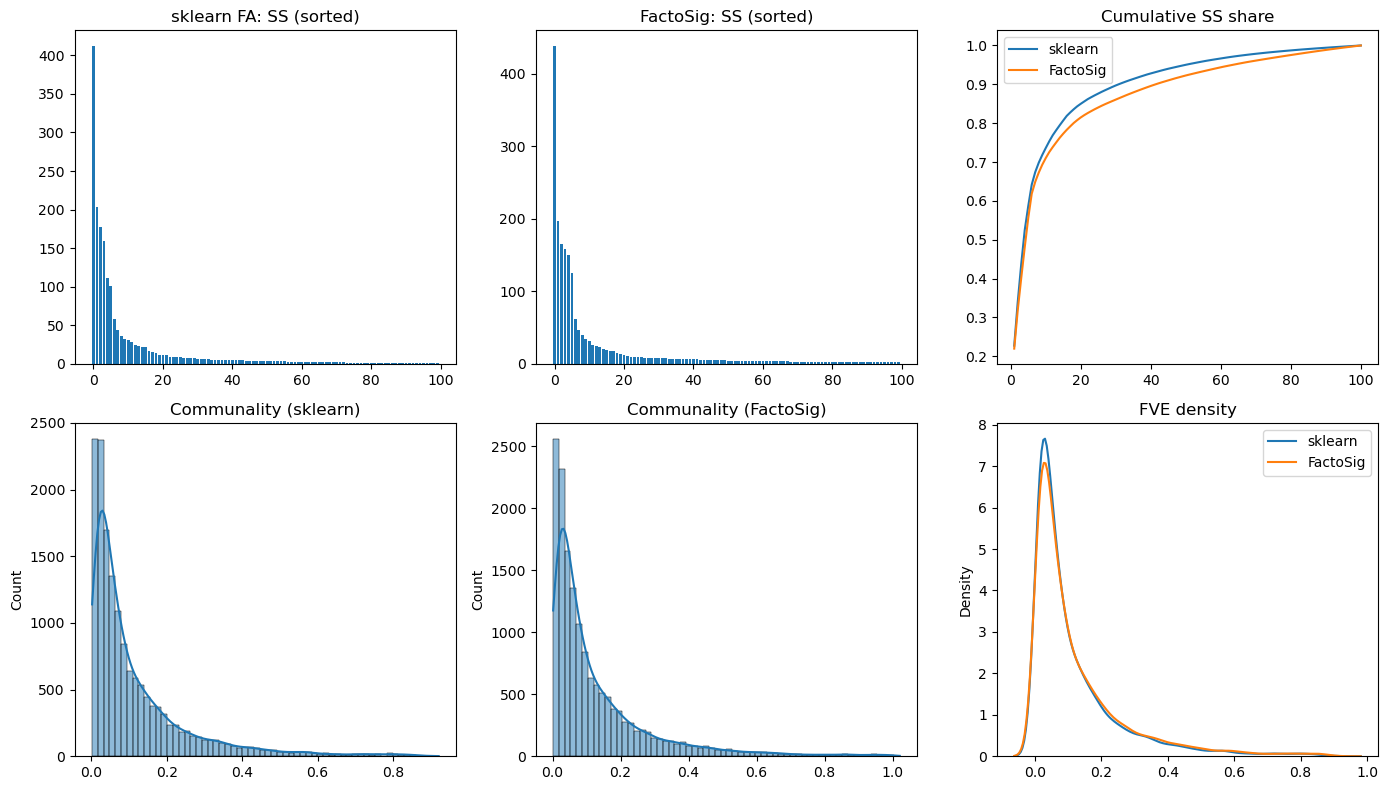

In [9]:
# Extract loadings and psi
L_fa = np.asarray(adata_fa.varm.get("sklearn_fa_loadings"))
psi_fa = np.asarray(adata_fa.var.get("sklearn_fa_psi"))
L_fs = np.asarray(adata_fs.varm.get("fs_loadings"))
psi_fs = np.asarray(adata_fs.var.get("fs_psi", np.nan))

print(f"shape of unique residual variance psi_fs: {psi_fs.shape} and psi_fa: {psi_fa.shape}")
assert L_fa.shape == L_fs.shape, (L_fa.shape, L_fs.shape)

# SS and communality
ss_fa = (L_fa**2).sum(axis=0)     # sum of squared is calculated as a row-wise sum
ss_fs = (L_fs**2).sum(axis=0)
comm_fa = (L_fa**2).sum(axis=1)   # communality is calculated as a column-wise sum
comm_fs = (L_fs**2).sum(axis=1)

# If ψ is not provided for FactoSig, estimate it from residuals
if np.isscalar(psi_fs) or np.isnan(psi_fs).all():
    print("No ψ provided for FactoSig; estimating from residuals")
    # Fallback estimate ψ from residuals if fs_psi missing
    Z = np.asarray(adata_fs.obsm["fs_scores"])
    X = np.asarray(adata_fs.X.A if hasattr(adata_fs.X, "A") else adata_fs.X)
    R = X - Z @ L_fs.T
    dof = max(X.shape[0] - L_fs.shape[1], 1)
    psi_fs = (R**2).sum(axis=0) / float(dof)

# FVE means the proportion of variance explained by the factor, 
# doesn't include the residual variance
fve_fa = comm_fa / (comm_fa + psi_fa)
fve_fs = comm_fs / (comm_fs + psi_fs)

# Plots
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0,0].bar(np.arange(L_fa.shape[1]), np.sort(ss_fa)[::-1])
axes[0,0].set_title("sklearn FA: SS (sorted)")
axes[0,1].bar(np.arange(L_fs.shape[1]), np.sort(ss_fs)[::-1])
axes[0,1].set_title("FactoSig: SS (sorted)")
axes[0,2].plot(np.arange(1, L_fa.shape[1]+1), np.cumsum(np.sort(ss_fa)[::-1]) / ss_fa.sum(), label="sklearn")
axes[0,2].plot(np.arange(1, L_fs.shape[1]+1), np.cumsum(np.sort(ss_fs)[::-1]) / ss_fs.sum(), label="FactoSig")
axes[0,2].set_title("Cumulative SS share")
axes[0,2].legend()

sns.histplot(comm_fa, bins=60, kde=True, ax=axes[1,0])
sns.histplot(comm_fs, bins=60, kde=True, ax=axes[1,1])
axes[1,0].set_title("Communality (sklearn)")
axes[1,1].set_title("Communality (FactoSig)")

sns.kdeplot(fve_fa, ax=axes[1,2], label="sklearn")
sns.kdeplot(fve_fs, ax=axes[1,2], label="FactoSig")
axes[1,2].set_title("FVE density")
axes[1,2].legend()
plt.tight_layout()
plt.show()

### Subspace similarity and factor alignment

- Compute principal angles between colspaces of loadings (sklearn vs FactoSig)
- Orthogonal Procrustes to align FactoSig loadings to sklearn; then compare column-wise correlations and top-|λ| overlaps.


In [6]:
from scipy.linalg import svd, orthogonal_procrustes

# Principal angles between column spaces
# Orthonormal bases via SVD
U1, _, _ = svd(L_fa, full_matrices=False)
U2, _, _ = svd(L_fs, full_matrices=False)
M = U1.T @ U2
_, s, _ = svd(M)
# s are cosines of principal angles
angles = np.arccos(np.clip(s, -1.0, 1.0))

print("Principal angles (deg):", np.round(np.degrees(angles[:10]), 2))

# Procrustes align FactoSig loadings to sklearn loadings (same dimensionality)
R, scale = orthogonal_procrustes(L_fs, L_fa)
L_fs_aligned = L_fs @ R

# Column-wise correlations after alignment
corrs = []
for j in range(L_fa.shape[1]):
    a = L_fa[:, j]
    b = L_fs_aligned[:, j]
    ra = np.std(a) > 0 and np.std(b) > 0
    corrs.append(np.corrcoef(a, b)[0,1] if ra else np.nan)

print("Median column corr after alignment:", np.nanmedian(corrs))

# Top-|lambda| overlap per factor
def top_overlap(A: np.ndarray, B: np.ndarray, N: int = 200) -> float:
    idxA = np.argsort(-np.abs(A))[:N]
    idxB = np.argsort(-np.abs(B))[:N]
    return len(set(idxA) & set(idxB)) / float(N)

overlaps = [top_overlap(L_fa[:, j], L_fs_aligned[:, j], N=200) for j in range(L_fa.shape[1])]
print("Median top-200 |λ| overlap:", float(np.median(overlaps)))


Principal angles (deg): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Median column corr after alignment: 0.9929963962838345
Median top-200 |λ| overlap: 0.94


### Factor-level comparisons and example plots

- Show a few factors with highest/lowest alignment correlations
- For those, plot scatter of loadings (sklearn vs aligned FactoSig) and rank-overlap curves.


### FVE on HVGs vs all genes

We define HVGs from `adata.raw` if available (Scanpy’s `highly_variable_genes`); otherwise we fall back to top genes by communality as a proxy. We then compare FVE distributions for HVGs vs all genes.


HVGs selected: 3000 / 15679


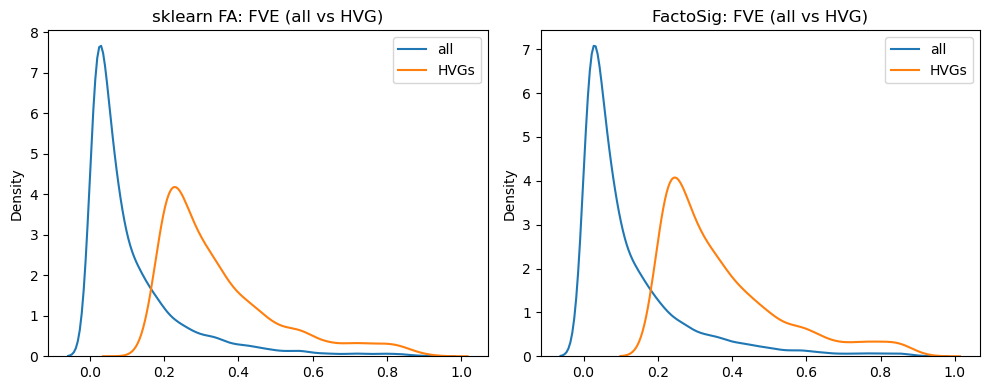

In [7]:
# Determine HVG mask
hvg_mask = None
try:
    if hasattr(adata_fs, 'raw') and adata_fs.raw is not None and 'highly_variable' in adata_fs.raw.var.columns:
        # Align raw.var index to current var index if needed
        raw_to_current = adata_fs.raw.var_names.isin(adata_fs.var_names)
        if raw_to_current.sum() == adata_fs.n_vars:
            hvg_mask = np.asarray(adata_fs.raw.var['highly_variable'].values)
        else:
            # Map raw HVG flags onto current var
            raw_hvg = pd.Series(adata_fs.raw.var['highly_variable'].values, index=adata_fs.raw.var_names)
            hvg_mask = adata_fs.var_names.to_series().map(raw_hvg).fillna(False).astype(bool).values
except Exception:
    pass

if hvg_mask is None or hvg_mask.sum() == 0:
    # Fallback proxy: top 3000 genes by communality (FactoSig)
    top = min(3000, adata_fs.n_vars)
    idx = np.argsort(-comm_fs)[:top]
    hvg_mask = np.zeros(adata_fs.n_vars, dtype=bool)
    hvg_mask[idx] = True

print(f"HVGs selected: {int(hvg_mask.sum())} / {adata_fs.n_vars}")

# Compare FVE distributions
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.kdeplot(fve_fa, ax=axes[0], label='all')
sns.kdeplot(fve_fa[hvg_mask], ax=axes[0], label='HVGs')
axes[0].set_title('sklearn FA: FVE (all vs HVG)')
axes[0].legend()

sns.kdeplot(fve_fs, ax=axes[1], label='all')
sns.kdeplot(fve_fs[hvg_mask], ax=axes[1], label='HVGs')
axes[1].set_title('FactoSig: FVE (all vs HVG)')
axes[1].legend()
plt.tight_layout(); plt.show()


### FVE vs mean and vs CV

Using the analysis matrix in the transformed H5AD (or `.raw` if present), compute per-gene mean and CV, and visualize FVE_i against mean_i and CV_i.


ValueError: x and y must be the same size

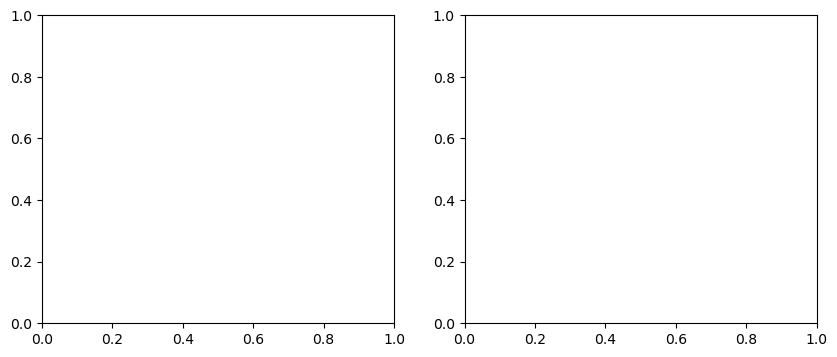

In [ ]:
from scipy import sparse

# Choose matrix to compute moments (prefer raw if available)
if hasattr(adata_fs, 'raw') and adata_fs.raw is not None:
    Xm = adata_fs.raw.X
else:
    Xm = adata_fs.X

if sparse.issparse(Xm):
    mean_g = np.asarray(Xm.mean(axis=0)).ravel()
    # CV with sparse: use E[X^2] - (E[X])^2
    sq_mean_g = np.asarray(Xm.power(2).mean(axis=0)).ravel()
    var_g = np.maximum(sq_mean_g - mean_g**2, 0.0)
else:
    Xd = np.asarray(Xm)
    mean_g = Xd.mean(axis=0)
    var_g = Xd.var(axis=0)

cv_g = np.sqrt(var_g) / (mean_g + 1e-12)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(mean_g, fve_fs, s=4, alpha=0.3)
axes[0].set_xlabel('gene mean')
axes[0].set_ylabel('FVE (FactoSig)')
axes[0].set_title('FVE vs gene mean')

axes[1].scatter(cv_g, fve_fs, s=4, alpha=0.3)
axes[1].set_xlabel('gene CV')
axes[1].set_ylabel('FVE (FactoSig)')
axes[1].set_title('FVE vs gene CV')
plt.tight_layout(); plt.show()


### Cached GSEA on loadings-only ranks for sklearn vs FactoSig

We mirror your earlier GSEA flow and cache under the experiment’s analysis path:
- `.../analysis/factor_interpretation/factosig_gsea/fa{j}/`
- `.../analysis/factor_interpretation/sklearn_gsea/fa{j}/`

We then plot #significant pathways (FDR<0.05) per factor for both methods.


In [10]:
from pathlib import Path
import pandas as pd

hallmark_gmt = "/home/minhang/mds_project/data/cohort_adata/gene_sets/h.all.v2024.1.Hs.symbols.gmt"
analysis_root = exp_dir / "analysis" / "factor_interpretation"
fs_out_root = analysis_root / "factosig_gsea"
fa_out_root = analysis_root / "sklearn_gsea"
fs_out_root.mkdir(parents=True, exist_ok=True)
fa_out_root.mkdir(parents=True, exist_ok=True)

In [ ]:
def run_or_read_prerank(series: pd.Series, gene_sets: str, out_dir: Path) -> pd.DataFrame:
    import gseapy as gp
    out_dir.mkdir(parents=True, exist_ok=True)
    report_csv = out_dir / "gseapy.gene_set.prerank.report.csv"
    if report_csv.exists():
        try:
            df = pd.read_csv(report_csv, sep="\t")
        except Exception:
            df = pd.read_csv(report_csv)
        return df
    df_rnk = series.reset_index()
    df_rnk.columns = ["gene", "score"]
    res = gp.prerank(
        rnk=df_rnk,
        gene_sets=gene_sets,
        threads=4,
        permutation_num=1000,
        outdir=str(out_dir),
        seed=0,
        min_size=10,
        max_size=5000,
        no_plot=True,
        format="png",
    )
    return res.res2d.copy()

# Build rank series by raw loadings
genes = adata_fs.var_names.to_numpy()
rank_fs = {j: pd.Series(L_fs[:, j], index=genes).sort_values(ascending=False) for j in range(L_fs.shape[1])}
rank_fa = {j: pd.Series(L_fa[:, j], index=genes).sort_values(ascending=False) for j in range(L_fa.shape[1])}

alpha = 0.05
summary_counts = []
for j in range(L_fa.shape[1]):
    fs_dir_j = fs_out_root / f"fa{j+1}"
    fa_dir_j = fa_out_root / f"fa{j+1}"
    df_fs = run_or_read_prerank(rank_fs[j], hallmark_gmt, fs_dir_j)
    df_fa = run_or_read_prerank(rank_fa[j], hallmark_gmt, fa_dir_j)

    # tolerant columns
    qcol_fs = "FDR q-val" if "FDR q-val" in df_fs.columns else ("fdr" if "fdr" in df_fs.columns else None)
    qcol_fa = "FDR q-val" if "FDR q-val" in df_fa.columns else ("fdr" if "fdr" in df_fa.columns else None)
    n_sig_fs = int((df_fs[qcol_fs] < alpha).sum()) if qcol_fs else np.nan
    n_sig_fa = int((df_fa[qcol_fa] < alpha).sum()) if qcol_fa else np.nan

    summary_counts.append({"factor": j, "n_sig_factosig": n_sig_fs, "n_sig_sklearn": n_sig_fa})

summary_counts_df = pd.DataFrame(summary_counts)
summary_counts_df.head()


2025-10-24 13:25:20,603 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-10-24 13:25:23,302 [WARNING] Duplicated values found in preranked stats: 0.03% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-10-24 13:25:25,677 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-10-24 13:25:27,927 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-10-24 13:25:32,517 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-10-24 13:25:34,848 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be

factor  n_sig_factosig  n_sig_sklearn
0       0               6             18
1       1               8             30
2       2               4             13
3       3              10              9
4       4              14              3

In [11]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sc_classification.utils.experiment_analysis import ExperimentAnalyzer
from pathlib import Path

# This code assumes that `exp_dir`, `L_fa`, `hallmark_gmt`, `fs_out_root`, 
# and `fa_out_root` are defined in previous cells of your notebook.
exp_dir = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c")
# Initialize the ExperimentAnalyzer with the base directory for experiments.
# `exp_dir` points to a specific experiment, so its parent is the base directory.
try:
    experiments_base_dir = exp_dir.parent
    analyzer = ExperimentAnalyzer(str(experiments_base_dir))
    print(f"Initialized ExperimentAnalyzer with base directory: {experiments_base_dir}")
except NameError:
    print("Please make sure the `exp_dir` variable is defined before running this cell.")
    # You might need to define it like this:
    
    analyzer = None

# Helper function to generate the plot for a single factor's GSEA results
def generate_gsea_plot(analyzer_instance, csv_path, factor_name, gene_set_path, output_path):
    """Wrapper to call the private plotting method and handle file existence."""
    if not Path(csv_path).exists():
        print(f"CSV file not found, skipping plot for {factor_name}: {csv_path}")
        return
    
    print(f"Generating GSEA summary plot for {factor_name}...")
    try:
        # The _plot_gsea_results method is private, but we can call it for this purpose.
        analyzer_instance._plot_gsea_results(
            csv_path=str(csv_path),
            factor_name=factor_name,
            gene_set=gene_set_path,
            output_path=str(output_path)
        )
        print(f"  -> Saved plot to {output_path}")
    except Exception as e:
        print(f"  -> ERROR generating plot for {factor_name}: {e}")

if analyzer:
    # Loop through all factors and generate plots for both methods
    n_factors = L_fa.shape[1]
    for j in range(n_factors):
        factor_num = j + 1
        
        # --- Plot for FactoSig factor ---
        fs_factor_dir = fs_out_root / f"fa{factor_num}"
        fs_csv = fs_factor_dir / "gseapy.gene_set.prerank.report.csv"
        fs_plot_path = fs_factor_dir / f"GSEA_summary_barplot_fa{factor_num}.png"
        generate_gsea_plot(
            analyzer,
            fs_csv,
            f"FactoSig Factor {factor_num}",
            hallmark_gmt,
            fs_plot_path
        )
        
        # --- Plot for Sklearn FA factor ---
        fa_factor_dir = fa_out_root / f"fa{factor_num}"
        fa_csv = fa_factor_dir / "gseapy.gene_set.prerank.report.csv"
        fa_plot_path = fa_factor_dir / f"GSEA_summary_barplot_fa{factor_num}.png"
        generate_gsea_plot(
            analyzer,
            fa_csv,
            f"Sklearn FA Factor {factor_num}",
            hallmark_gmt,
            fa_plot_path
        )

    print("\nFinished generating all GSEA summary plots.")

Initialized ExperimentAnalyzer with base directory: /home/minhang/mds_project/sc_classification/scripts/experiments
Generating GSEA summary plot for FactoSig Factor 1...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa1/GSEA_summary_barplot_fa1.png
Generating GSEA summary plot for Sklearn FA Factor 1...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa1/GSEA_summary_barplot_fa1.png
Generating GSEA summary plot for FactoSig Factor 2...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa2/GSEA_summary_barplot_fa2.png
Generating GSEA summary plot for Sklearn FA Factor 2...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa2/GSEA_summary_barplot_fa2.png
Generating GSEA summary plot for FactoSig Factor 3...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa3/GSEA_summary_barplot_fa3.png
Generating GSEA summary plot for Sklearn FA Factor 3...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa3/GSEA_summary_barplot_fa3.png
Generating GSEA summary plot for FactoSig Factor 4...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa4/GSEA_summary_barplot_fa4.png
Generating GSEA summary plot for Sklearn FA Factor 4...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa4/GSEA_summary_barplot_fa4.png
Generating GSEA summary plot for FactoSig Factor 5...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa5/GSEA_summary_barplot_fa5.png
Generating GSEA summary plot for Sklearn FA Factor 5...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa5/GSEA_summary_barplot_fa5.png
Generating GSEA summary plot for FactoSig Factor 6...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa6/GSEA_summary_barplot_fa6.png
Generating GSEA summary plot for Sklearn FA Factor 6...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa6/GSEA_summary_barplot_fa6.png
Generating GSEA summary plot for FactoSig Factor 7...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa7/GSEA_summary_barplot_fa7.png
Generating GSEA summary plot for Sklearn FA Factor 7...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa7/GSEA_summary_barplot_fa7.png
Generating GSEA summary plot for FactoSig Factor 8...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa8/GSEA_summary_barplot_fa8.png
Generating GSEA summary plot for Sklearn FA Factor 8...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa8/GSEA_summary_barplot_fa8.png
Generating GSEA summary plot for FactoSig Factor 9...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa9/GSEA_summary_barplot_fa9.png
Generating GSEA summary plot for Sklearn FA Factor 9...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa9/GSEA_summary_barplot_fa9.png
Generating GSEA summary plot for FactoSig Factor 10...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa10/GSEA_summary_barplot_fa10.png
Generating GSEA summary plot for Sklearn FA Factor 10...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa10/GSEA_summary_barplot_fa10.png
Generating GSEA summary plot for FactoSig Factor 11...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa11/GSEA_summary_barplot_fa11.png
Generating GSEA summary plot for Sklearn FA Factor 11...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa11/GSEA_summary_barplot_fa11.png
Generating GSEA summary plot for FactoSig Factor 12...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa12/GSEA_summary_barplot_fa12.png
Generating GSEA summary plot for Sklearn FA Factor 12...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa12/GSEA_summary_barplot_fa12.png
Generating GSEA summary plot for FactoSig Factor 13...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa13/GSEA_summary_barplot_fa13.png
Generating GSEA summary plot for Sklearn FA Factor 13...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa13/GSEA_summary_barplot_fa13.png
Generating GSEA summary plot for FactoSig Factor 14...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa14/GSEA_summary_barplot_fa14.png
Generating GSEA summary plot for Sklearn FA Factor 14...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa14/GSEA_summary_barplot_fa14.png
Generating GSEA summary plot for FactoSig Factor 15...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa15/GSEA_summary_barplot_fa15.png
Generating GSEA summary plot for Sklearn FA Factor 15...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa15/GSEA_summary_barplot_fa15.png
Generating GSEA summary plot for FactoSig Factor 16...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa16/GSEA_summary_barplot_fa16.png
Generating GSEA summary plot for Sklearn FA Factor 16...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa16/GSEA_summary_barplot_fa16.png
Generating GSEA summary plot for FactoSig Factor 17...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa17/GSEA_summary_barplot_fa17.png
Generating GSEA summary plot for Sklearn FA Factor 17...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa17/GSEA_summary_barplot_fa17.png
Generating GSEA summary plot for FactoSig Factor 18...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa18/GSEA_summary_barplot_fa18.png
Generating GSEA summary plot for Sklearn FA Factor 18...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa18/GSEA_summary_barplot_fa18.png
Generating GSEA summary plot for FactoSig Factor 19...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa19/GSEA_summary_barplot_fa19.png
Generating GSEA summary plot for Sklearn FA Factor 19...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa19/GSEA_summary_barplot_fa19.png
Generating GSEA summary plot for FactoSig Factor 20...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa20/GSEA_summary_barplot_fa20.png
Generating GSEA summary plot for Sklearn FA Factor 20...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa20/GSEA_summary_barplot_fa20.png
Generating GSEA summary plot for FactoSig Factor 21...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa21/GSEA_summary_barplot_fa21.png
Generating GSEA summary plot for Sklearn FA Factor 21...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa21/GSEA_summary_barplot_fa21.png
Generating GSEA summary plot for FactoSig Factor 22...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa22/GSEA_summary_barplot_fa22.png
Generating GSEA summary plot for Sklearn FA Factor 22...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa22/GSEA_summary_barplot_fa22.png
Generating GSEA summary plot for FactoSig Factor 23...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa23/GSEA_summary_barplot_fa23.png
Generating GSEA summary plot for Sklearn FA Factor 23...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa23/GSEA_summary_barplot_fa23.png
Generating GSEA summary plot for FactoSig Factor 24...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa24/GSEA_summary_barplot_fa24.png
Generating GSEA summary plot for Sklearn FA Factor 24...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa24/GSEA_summary_barplot_fa24.png
Generating GSEA summary plot for FactoSig Factor 25...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa25/GSEA_summary_barplot_fa25.png
Generating GSEA summary plot for Sklearn FA Factor 25...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa25/GSEA_summary_barplot_fa25.png
Generating GSEA summary plot for FactoSig Factor 26...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa26/GSEA_summary_barplot_fa26.png
Generating GSEA summary plot for Sklearn FA Factor 26...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa26/GSEA_summary_barplot_fa26.png
Generating GSEA summary plot for FactoSig Factor 27...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa27/GSEA_summary_barplot_fa27.png
Generating GSEA summary plot for Sklearn FA Factor 27...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa27/GSEA_summary_barplot_fa27.png
Generating GSEA summary plot for FactoSig Factor 28...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa28/GSEA_summary_barplot_fa28.png
Generating GSEA summary plot for Sklearn FA Factor 28...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa28/GSEA_summary_barplot_fa28.png
Generating GSEA summary plot for FactoSig Factor 29...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa29/GSEA_summary_barplot_fa29.png
Generating GSEA summary plot for Sklearn FA Factor 29...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa29/GSEA_summary_barplot_fa29.png
Generating GSEA summary plot for FactoSig Factor 30...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa30/GSEA_summary_barplot_fa30.png
Generating GSEA summary plot for Sklearn FA Factor 30...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa30/GSEA_summary_barplot_fa30.png
Generating GSEA summary plot for FactoSig Factor 31...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa31/GSEA_summary_barplot_fa31.png
Generating GSEA summary plot for Sklearn FA Factor 31...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa31/GSEA_summary_barplot_fa31.png
Generating GSEA summary plot for FactoSig Factor 32...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa32/GSEA_summary_barplot_fa32.png
Generating GSEA summary plot for Sklearn FA Factor 32...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa32/GSEA_summary_barplot_fa32.png
Generating GSEA summary plot for FactoSig Factor 33...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa33/GSEA_summary_barplot_fa33.png
Generating GSEA summary plot for Sklearn FA Factor 33...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa33/GSEA_summary_barplot_fa33.png
Generating GSEA summary plot for FactoSig Factor 34...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa34/GSEA_summary_barplot_fa34.png
Generating GSEA summary plot for Sklearn FA Factor 34...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa34/GSEA_summary_barplot_fa34.png
Generating GSEA summary plot for FactoSig Factor 35...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa35/GSEA_summary_barplot_fa35.png
Generating GSEA summary plot for Sklearn FA Factor 35...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa35/GSEA_summary_barplot_fa35.png
Generating GSEA summary plot for FactoSig Factor 36...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa36/GSEA_summary_barplot_fa36.png
Generating GSEA summary plot for Sklearn FA Factor 36...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa36/GSEA_summary_barplot_fa36.png
Generating GSEA summary plot for FactoSig Factor 37...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa37/GSEA_summary_barplot_fa37.png
Generating GSEA summary plot for Sklearn FA Factor 37...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa37/GSEA_summary_barplot_fa37.png
Generating GSEA summary plot for FactoSig Factor 38...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa38/GSEA_summary_barplot_fa38.png
Generating GSEA summary plot for Sklearn FA Factor 38...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa38/GSEA_summary_barplot_fa38.png
Generating GSEA summary plot for FactoSig Factor 39...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa39/GSEA_summary_barplot_fa39.png
Generating GSEA summary plot for Sklearn FA Factor 39...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa39/GSEA_summary_barplot_fa39.png
Generating GSEA summary plot for FactoSig Factor 40...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa40/GSEA_summary_barplot_fa40.png
Generating GSEA summary plot for Sklearn FA Factor 40...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa40/GSEA_summary_barplot_fa40.png
Generating GSEA summary plot for FactoSig Factor 41...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa41/GSEA_summary_barplot_fa41.png
Generating GSEA summary plot for Sklearn FA Factor 41...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa41/GSEA_summary_barplot_fa41.png
Generating GSEA summary plot for FactoSig Factor 42...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa42/GSEA_summary_barplot_fa42.png
Generating GSEA summary plot for Sklearn FA Factor 42...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa42/GSEA_summary_barplot_fa42.png
Generating GSEA summary plot for FactoSig Factor 43...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa43/GSEA_summary_barplot_fa43.png
Generating GSEA summary plot for Sklearn FA Factor 43...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa43/GSEA_summary_barplot_fa43.png
Generating GSEA summary plot for FactoSig Factor 44...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa44/GSEA_summary_barplot_fa44.png
Generating GSEA summary plot for Sklearn FA Factor 44...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa44/GSEA_summary_barplot_fa44.png
Generating GSEA summary plot for FactoSig Factor 45...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa45/GSEA_summary_barplot_fa45.png
Generating GSEA summary plot for Sklearn FA Factor 45...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa45/GSEA_summary_barplot_fa45.png
Generating GSEA summary plot for FactoSig Factor 46...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa46/GSEA_summary_barplot_fa46.png
Generating GSEA summary plot for Sklearn FA Factor 46...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa46/GSEA_summary_barplot_fa46.png
Generating GSEA summary plot for FactoSig Factor 47...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa47/GSEA_summary_barplot_fa47.png
Generating GSEA summary plot for Sklearn FA Factor 47...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa47/GSEA_summary_barplot_fa47.png
Generating GSEA summary plot for FactoSig Factor 48...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa48/GSEA_summary_barplot_fa48.png
Generating GSEA summary plot for Sklearn FA Factor 48...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa48/GSEA_summary_barplot_fa48.png
Generating GSEA summary plot for FactoSig Factor 49...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa49/GSEA_summary_barplot_fa49.png
Generating GSEA summary plot for Sklearn FA Factor 49...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa49/GSEA_summary_barplot_fa49.png
Generating GSEA summary plot for FactoSig Factor 50...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa50/GSEA_summary_barplot_fa50.png
Generating GSEA summary plot for Sklearn FA Factor 50...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa50/GSEA_summary_barplot_fa50.png
Generating GSEA summary plot for FactoSig Factor 51...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa51/GSEA_summary_barplot_fa51.png
Generating GSEA summary plot for Sklearn FA Factor 51...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa51/GSEA_summary_barplot_fa51.png
Generating GSEA summary plot for FactoSig Factor 52...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa52/GSEA_summary_barplot_fa52.png
Generating GSEA summary plot for Sklearn FA Factor 52...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa52/GSEA_summary_barplot_fa52.png
Generating GSEA summary plot for FactoSig Factor 53...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa53/GSEA_summary_barplot_fa53.png
Generating GSEA summary plot for Sklearn FA Factor 53...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa53/GSEA_summary_barplot_fa53.png
Generating GSEA summary plot for FactoSig Factor 54...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa54/GSEA_summary_barplot_fa54.png
Generating GSEA summary plot for Sklearn FA Factor 54...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa54/GSEA_summary_barplot_fa54.png
Generating GSEA summary plot for FactoSig Factor 55...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa55/GSEA_summary_barplot_fa55.png
Generating GSEA summary plot for Sklearn FA Factor 55...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa55/GSEA_summary_barplot_fa55.png
Generating GSEA summary plot for FactoSig Factor 56...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa56/GSEA_summary_barplot_fa56.png
Generating GSEA summary plot for Sklearn FA Factor 56...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa56/GSEA_summary_barplot_fa56.png
Generating GSEA summary plot for FactoSig Factor 57...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa57/GSEA_summary_barplot_fa57.png
Generating GSEA summary plot for Sklearn FA Factor 57...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa57/GSEA_summary_barplot_fa57.png
Generating GSEA summary plot for FactoSig Factor 58...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa58/GSEA_summary_barplot_fa58.png
Generating GSEA summary plot for Sklearn FA Factor 58...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa58/GSEA_summary_barplot_fa58.png
Generating GSEA summary plot for FactoSig Factor 59...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa59/GSEA_summary_barplot_fa59.png
Generating GSEA summary plot for Sklearn FA Factor 59...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa59/GSEA_summary_barplot_fa59.png
Generating GSEA summary plot for FactoSig Factor 60...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa60/GSEA_summary_barplot_fa60.png
Generating GSEA summary plot for Sklearn FA Factor 60...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa60/GSEA_summary_barplot_fa60.png
Generating GSEA summary plot for FactoSig Factor 61...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa61/GSEA_summary_barplot_fa61.png
Generating GSEA summary plot for Sklearn FA Factor 61...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa61/GSEA_summary_barplot_fa61.png
Generating GSEA summary plot for FactoSig Factor 62...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa62/GSEA_summary_barplot_fa62.png
Generating GSEA summary plot for Sklearn FA Factor 62...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa62/GSEA_summary_barplot_fa62.png
Generating GSEA summary plot for FactoSig Factor 63...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa63/GSEA_summary_barplot_fa63.png
Generating GSEA summary plot for Sklearn FA Factor 63...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa63/GSEA_summary_barplot_fa63.png
Generating GSEA summary plot for FactoSig Factor 64...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa64/GSEA_summary_barplot_fa64.png
Generating GSEA summary plot for Sklearn FA Factor 64...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa64/GSEA_summary_barplot_fa64.png
Generating GSEA summary plot for FactoSig Factor 65...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa65/GSEA_summary_barplot_fa65.png
Generating GSEA summary plot for Sklearn FA Factor 65...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa65/GSEA_summary_barplot_fa65.png
Generating GSEA summary plot for FactoSig Factor 66...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa66/GSEA_summary_barplot_fa66.png
Generating GSEA summary plot for Sklearn FA Factor 66...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa66/GSEA_summary_barplot_fa66.png
Generating GSEA summary plot for FactoSig Factor 67...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa67/GSEA_summary_barplot_fa67.png
Generating GSEA summary plot for Sklearn FA Factor 67...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa67/GSEA_summary_barplot_fa67.png
Generating GSEA summary plot for FactoSig Factor 68...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa68/GSEA_summary_barplot_fa68.png
Generating GSEA summary plot for Sklearn FA Factor 68...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa68/GSEA_summary_barplot_fa68.png
Generating GSEA summary plot for FactoSig Factor 69...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa69/GSEA_summary_barplot_fa69.png
Generating GSEA summary plot for Sklearn FA Factor 69...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa69/GSEA_summary_barplot_fa69.png
Generating GSEA summary plot for FactoSig Factor 70...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa70/GSEA_summary_barplot_fa70.png
Generating GSEA summary plot for Sklearn FA Factor 70...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa70/GSEA_summary_barplot_fa70.png
Generating GSEA summary plot for FactoSig Factor 71...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa71/GSEA_summary_barplot_fa71.png
Generating GSEA summary plot for Sklearn FA Factor 71...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa71/GSEA_summary_barplot_fa71.png
Generating GSEA summary plot for FactoSig Factor 72...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa72/GSEA_summary_barplot_fa72.png
Generating GSEA summary plot for Sklearn FA Factor 72...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa72/GSEA_summary_barplot_fa72.png
Generating GSEA summary plot for FactoSig Factor 73...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa73/GSEA_summary_barplot_fa73.png
Generating GSEA summary plot for Sklearn FA Factor 73...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa73/GSEA_summary_barplot_fa73.png
Generating GSEA summary plot for FactoSig Factor 74...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa74/GSEA_summary_barplot_fa74.png
Generating GSEA summary plot for Sklearn FA Factor 74...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa74/GSEA_summary_barplot_fa74.png
Generating GSEA summary plot for FactoSig Factor 75...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa75/GSEA_summary_barplot_fa75.png
Generating GSEA summary plot for Sklearn FA Factor 75...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa75/GSEA_summary_barplot_fa75.png
Generating GSEA summary plot for FactoSig Factor 76...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa76/GSEA_summary_barplot_fa76.png
Generating GSEA summary plot for Sklearn FA Factor 76...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa76/GSEA_summary_barplot_fa76.png
Generating GSEA summary plot for FactoSig Factor 77...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa77/GSEA_summary_barplot_fa77.png
Generating GSEA summary plot for Sklearn FA Factor 77...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa77/GSEA_summary_barplot_fa77.png
Generating GSEA summary plot for FactoSig Factor 78...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa78/GSEA_summary_barplot_fa78.png
Generating GSEA summary plot for Sklearn FA Factor 78...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa78/GSEA_summary_barplot_fa78.png
Generating GSEA summary plot for FactoSig Factor 79...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa79/GSEA_summary_barplot_fa79.png
Generating GSEA summary plot for Sklearn FA Factor 79...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa79/GSEA_summary_barplot_fa79.png
Generating GSEA summary plot for FactoSig Factor 80...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa80/GSEA_summary_barplot_fa80.png
Generating GSEA summary plot for Sklearn FA Factor 80...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa80/GSEA_summary_barplot_fa80.png
Generating GSEA summary plot for FactoSig Factor 81...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa81/GSEA_summary_barplot_fa81.png
Generating GSEA summary plot for Sklearn FA Factor 81...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa81/GSEA_summary_barplot_fa81.png
Generating GSEA summary plot for FactoSig Factor 82...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa82/GSEA_summary_barplot_fa82.png
Generating GSEA summary plot for Sklearn FA Factor 82...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa82/GSEA_summary_barplot_fa82.png
Generating GSEA summary plot for FactoSig Factor 83...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa83/GSEA_summary_barplot_fa83.png
Generating GSEA summary plot for Sklearn FA Factor 83...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa83/GSEA_summary_barplot_fa83.png
Generating GSEA summary plot for FactoSig Factor 84...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa84/GSEA_summary_barplot_fa84.png
Generating GSEA summary plot for Sklearn FA Factor 84...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa84/GSEA_summary_barplot_fa84.png
Generating GSEA summary plot for FactoSig Factor 85...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa85/GSEA_summary_barplot_fa85.png
Generating GSEA summary plot for Sklearn FA Factor 85...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa85/GSEA_summary_barplot_fa85.png
Generating GSEA summary plot for FactoSig Factor 86...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa86/GSEA_summary_barplot_fa86.png
Generating GSEA summary plot for Sklearn FA Factor 86...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa86/GSEA_summary_barplot_fa86.png
Generating GSEA summary plot for FactoSig Factor 87...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa87/GSEA_summary_barplot_fa87.png
Generating GSEA summary plot for Sklearn FA Factor 87...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa87/GSEA_summary_barplot_fa87.png
Generating GSEA summary plot for FactoSig Factor 88...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa88/GSEA_summary_barplot_fa88.png
Generating GSEA summary plot for Sklearn FA Factor 88...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa88/GSEA_summary_barplot_fa88.png
Generating GSEA summary plot for FactoSig Factor 89...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa89/GSEA_summary_barplot_fa89.png
Generating GSEA summary plot for Sklearn FA Factor 89...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa89/GSEA_summary_barplot_fa89.png
Generating GSEA summary plot for FactoSig Factor 90...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa90/GSEA_summary_barplot_fa90.png
Generating GSEA summary plot for Sklearn FA Factor 90...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa90/GSEA_summary_barplot_fa90.png
Generating GSEA summary plot for FactoSig Factor 91...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa91/GSEA_summary_barplot_fa91.png
Generating GSEA summary plot for Sklearn FA Factor 91...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa91/GSEA_summary_barplot_fa91.png
Generating GSEA summary plot for FactoSig Factor 92...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa92/GSEA_summary_barplot_fa92.png
Generating GSEA summary plot for Sklearn FA Factor 92...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa92/GSEA_summary_barplot_fa92.png
Generating GSEA summary plot for FactoSig Factor 93...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa93/GSEA_summary_barplot_fa93.png
Generating GSEA summary plot for Sklearn FA Factor 93...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa93/GSEA_summary_barplot_fa93.png
Generating GSEA summary plot for FactoSig Factor 94...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa94/GSEA_summary_barplot_fa94.png
Generating GSEA summary plot for Sklearn FA Factor 94...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa94/GSEA_summary_barplot_fa94.png
Generating GSEA summary plot for FactoSig Factor 95...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa95/GSEA_summary_barplot_fa95.png
Generating GSEA summary plot for Sklearn FA Factor 95...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa95/GSEA_summary_barplot_fa95.png
Generating GSEA summary plot for FactoSig Factor 96...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa96/GSEA_summary_barplot_fa96.png
Generating GSEA summary plot for Sklearn FA Factor 96...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa96/GSEA_summary_barplot_fa96.png
Generating GSEA summary plot for FactoSig Factor 97...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa97/GSEA_summary_barplot_fa97.png
Generating GSEA summary plot for Sklearn FA Factor 97...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa97/GSEA_summary_barplot_fa97.png
Generating GSEA summary plot for FactoSig Factor 98...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa98/GSEA_summary_barplot_fa98.png
Generating GSEA summary plot for Sklearn FA Factor 98...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa98/GSEA_summary_barplot_fa98.png
Generating GSEA summary plot for FactoSig Factor 99...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa99/GSEA_summary_barplot_fa99.png
Generating GSEA summary plot for Sklearn FA Factor 99...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa99/GSEA_summary_barplot_fa99.png
Generating GSEA summary plot for FactoSig Factor 100...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/factosig_gsea/fa100/GSEA_summary_barplot_fa100.png
Generating GSEA summary plot for Sklearn FA Factor 100...


/home/minhang/mds_project/sc_classification/src/sc_classification/utils/experiment_analysis.py:2027: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  -> Saved plot to /home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c/analysis/factor_interpretation/sklearn_gsea/fa100/GSEA_summary_barplot_fa100.png

Finished generating all GSEA summary plots.


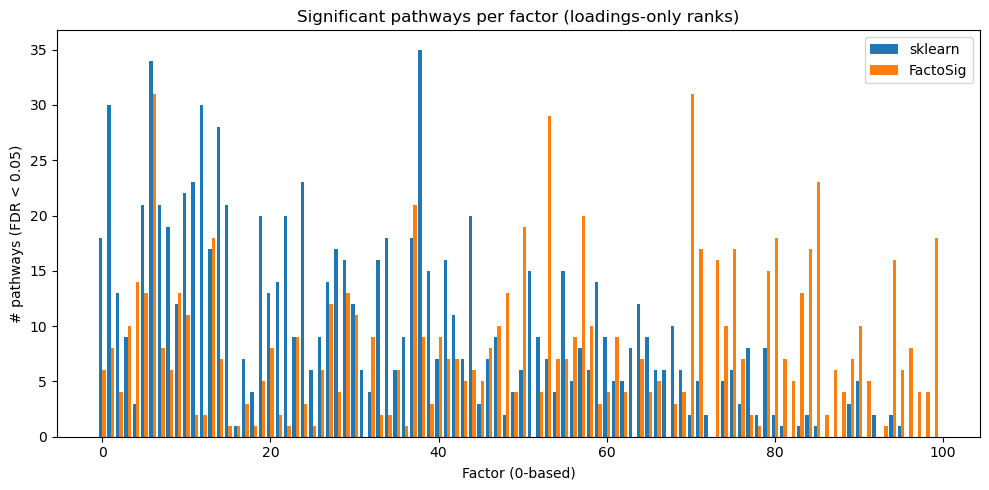

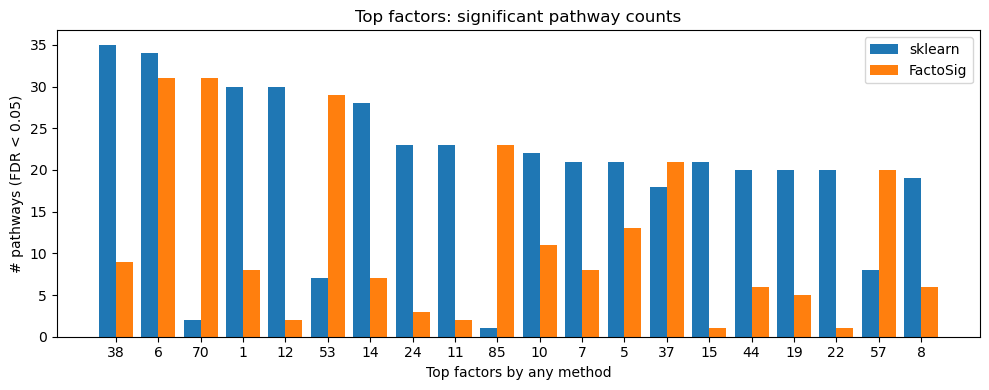

In [ ]:
# Plot factor-wise counts and a focused top-20 view
plt.figure(figsize=(10, 5))
idx = np.arange(summary_counts_df.shape[0])
bar_w = 0.4
plt.bar(idx - bar_w/2, summary_counts_df["n_sig_sklearn"], width=bar_w, label="sklearn")
plt.bar(idx + bar_w/2, summary_counts_df["n_sig_factosig"], width=bar_w, label="FactoSig")
plt.xlabel("Factor (0-based)")
plt.ylabel(f"# pathways (FDR < {alpha})")
plt.title("Significant pathways per factor (loadings-only ranks)")
plt.legend(); plt.tight_layout(); plt.show()

# Top-20 by max count across methods
top_idx = (
    summary_counts_df.assign(max_count=summary_counts_df[["n_sig_sklearn","n_sig_factosig"]].max(axis=1))
    .sort_values("max_count", ascending=False)
    .head(20)
    .index
)
sub = summary_counts_df.loc[top_idx]
plt.figure(figsize=(10, 4))
idx2 = np.arange(len(sub))
plt.bar(idx2 - bar_w/2, sub["n_sig_sklearn"], width=bar_w, label="sklearn")
plt.bar(idx2 + bar_w/2, sub["n_sig_factosig"], width=bar_w, label="FactoSig")
plt.xlabel("Top factors by any method")
plt.ylabel(f"# pathways (FDR < {alpha})")
plt.title("Top factors: significant pathway counts")
plt.xticks(idx2, sub["factor"].astype(int))
plt.legend(); plt.tight_layout(); plt.show()

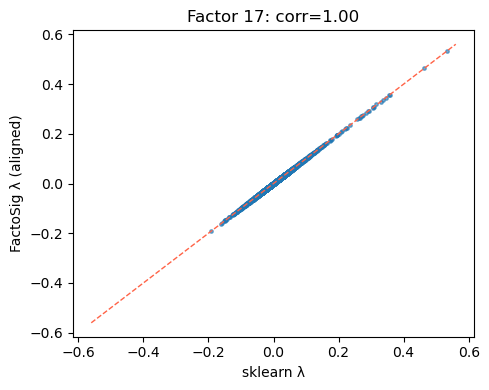

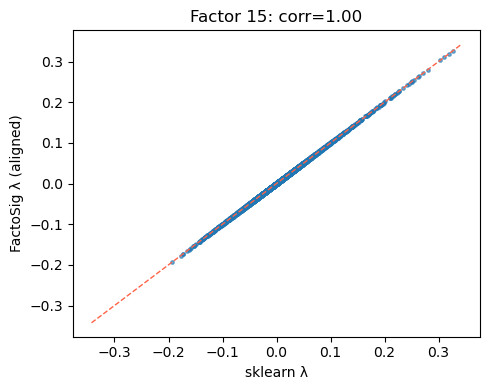

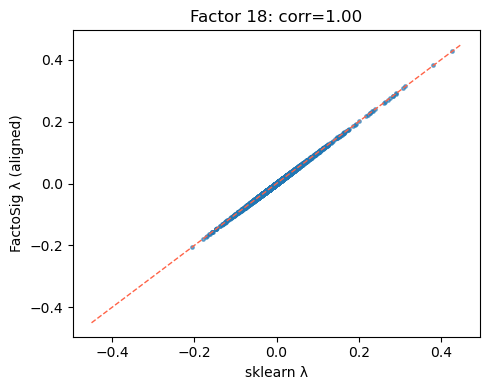

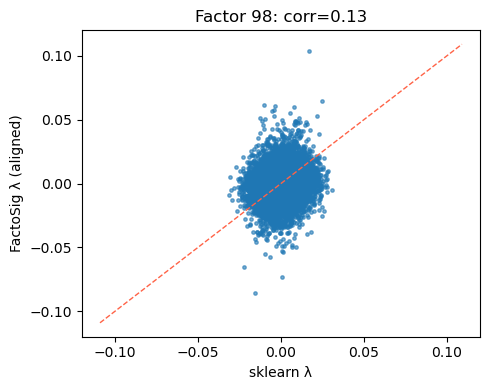

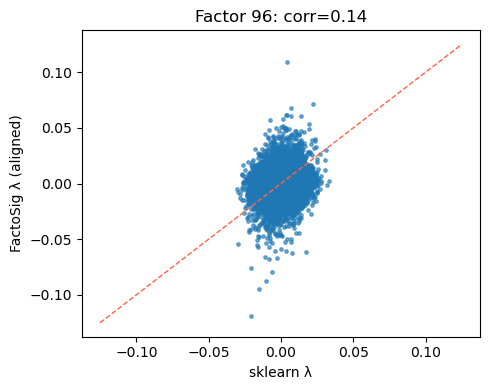

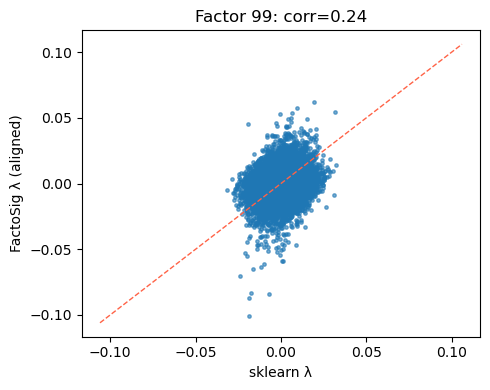

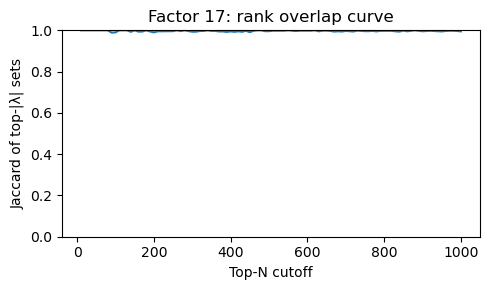

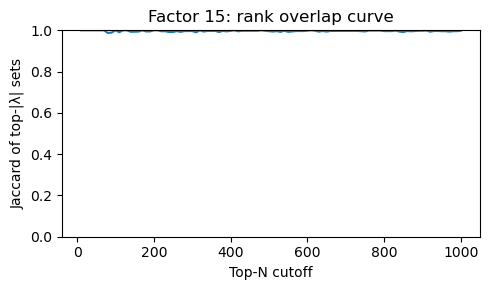

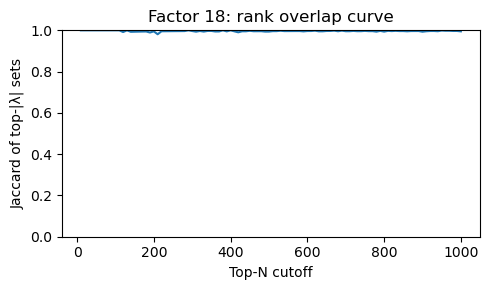

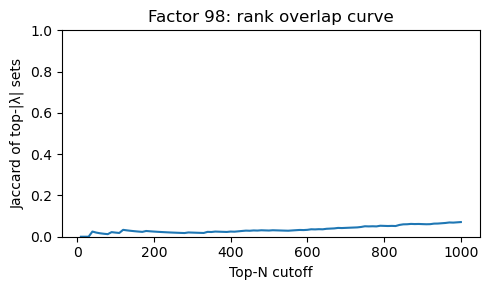

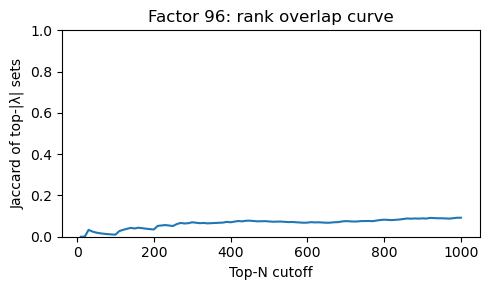

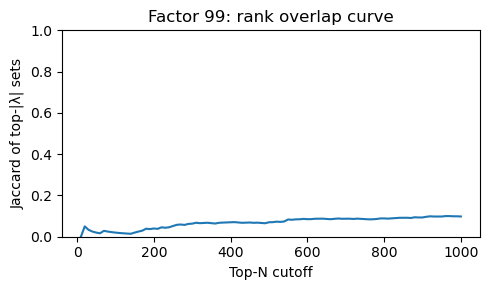

In [9]:
# Identify factors
order = np.argsort(np.nan_to_num(corrs, nan=-np.inf))
worst = order[:3]
best = order[-3:][::-1]
sel = list(best) + list(worst)

for j in sel:
    plt.figure(figsize=(5,4))
    plt.scatter(L_fa[:, j], L_fs_aligned[:, j], s=6, alpha=0.6)
    lim = 1.05 * np.nanmax(np.abs(np.concatenate([L_fa[:, j], L_fs_aligned[:, j]])))
    plt.plot([-lim, lim], [-lim, lim], ls='--', c='tomato', lw=1)
    plt.xlabel('sklearn λ')
    plt.ylabel('FactoSig λ (aligned)')
    plt.title(f"Factor {j}: corr={corrs[j]:.2f}")
    plt.tight_layout()
    plt.show()

# Rank-overlap curves
N_grid = np.arange(10, min(1000, L_fa.shape[0])+1, 10)
for j in sel:
    overlaps_curve = []
    for N in N_grid:
        overlaps_curve.append(
            top_overlap(L_fa[:, j], L_fs_aligned[:, j], N=int(N))
        )
    plt.figure(figsize=(5,3))
    plt.plot(N_grid, overlaps_curve)
    plt.ylim(0,1)
    plt.xlabel('Top-N cutoff')
    plt.ylabel('Jaccard of top-|λ| sets')
    plt.title(f"Factor {j}: rank overlap curve")
    plt.tight_layout()
    plt.show()


### 2D factor-space visualization per patient

Scatter plots of the top-2 factors (by per-patient signed AUC) for each method, colored by `CN.label` and `predicted.annotation`. This helps sanity-check separability and inspect coordination visually. Figures are shown inline only (not saved).


In [6]:
from pathlib import Path

# Update if your experiment id differs
exp_dir = Path("/home/minhang/mds_project/sc_classification/scripts/experiments/20251019_003140_compare_fa_100_none__f8a59d1c")
fa_h5ad = exp_dir / "models" / "sklearn_fa_100" / "transformed_data.h5ad"
fs_h5ad = exp_dir / "models" / "factosig_100" / "transformed_data.h5ad"

# Score keys saved by the compare script
sklearn_score_key = "X_sklearn_fa"
factosig_score_key = "fs_scores"

patient_col = "patient"
target_col = "CN.label"
positive_class = "cancer"

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import roc_auc_score

def signed_auc_per_patient(h5ad_path: str,
                           score_key: str,
                           patient_col: str = "patient",
                           target_col: str = "CN.label",
                           positive_class: str = "cancer") -> pd.DataFrame:
    ad = sc.read_h5ad(h5ad_path)
    if score_key not in ad.obsm:
        raise KeyError(f"Score key '{score_key}' not found in .obsm")
    if patient_col not in ad.obs or target_col not in ad.obs:
        raise KeyError(f"Missing obs columns: need '{patient_col}' and '{target_col}'")

    Z = np.asarray(ad.obsm[score_key])  # (n, k)
    y = (ad.obs[target_col].astype(str).values == positive_class).astype(int)
    patients = ad.obs[patient_col].astype(str).values
    uniq_patients = pd.unique(patients)

    k = Z.shape[1]
    cols = [f"factor_{i+1}" for i in range(k)]
    out = pd.DataFrame(index=uniq_patients, columns=cols, dtype=float)

    # loop through each patient
    for pid in uniq_patients:
        m = (patients == pid) # get the mask for the current patient    
        if m.sum() < 3: # if the patient has less than 3 cells, skip
            continue
        y_p = y[m] # get the labels for the current patient
        # need both classes for AUC
        if y_p.min() == y_p.max():
            continue
        Z_p = Z[m, :] # get the scores for the current patient from the scores matrix from factor analysis
        vals = []  # initialize the list to store the AUCs
        for j in range(k):
            try:
                # compute the AUC for the current factor, which is the probability of the positive class
                # convert to signed AUC
                auc = roc_auc_score(y_p, Z_p[:, j]) 
                vals.append(2.0 * (auc - 0.5))      # convert to signed AUC
            except Exception:
                vals.append(np.nan)                  # if error, append NaN
        out.loc[pid, :] = vals

    return out

# Compute signed AUC per patient for sklearn and FactoSig
df_auc_sklearn = signed_auc_per_patient(str(fa_h5ad), sklearn_score_key, patient_col, target_col, positive_class)
df_auc_factosig = signed_auc_per_patient(str(fs_h5ad), factosig_score_key, patient_col, target_col, positive_class)
df_auc_sklearn.head(), df_auc_factosig.head()

(     factor_1  factor_2  factor_3  factor_4  factor_5  factor_6  factor_7  \
 P01  0.006743  0.188158 -0.112356  0.249925 -0.513703 -0.137464  0.410779   
 P03 -0.092367 -0.163373 -0.017414 -0.053946 -0.647524 -0.654574  0.386923   
 P02  0.200867 -0.060467 -0.427984 -0.566436 -0.733605 -0.659177 -0.178288   
 P05 -0.259538 -0.075213 -0.206619  0.358711 -0.221386 -0.772006  0.458458   
 P04  0.085254  0.158048 -0.210507  0.029756 -0.348909 -0.457077  0.502217   
 
      factor_8  factor_9  factor_10  ...  factor_91  factor_92  factor_93  \
 P01  0.537800 -0.339077  -0.214272  ...   0.265980   0.275129  -0.282212   
 P03  0.200840  0.086861   0.581911  ...  -0.168704  -0.035868  -0.220983   
 P02  0.832149 -0.823163  -0.420869  ...  -0.136266   0.102307  -0.017408   
 P05  0.863422 -0.327051  -0.353539  ...   0.446851  -0.156918  -0.020168   
 P04  0.635000 -0.028150   0.313477  ...   0.374670   0.080170  -0.393304   
 
      factor_94  factor_95  factor_96  factor_97  factor_98  facto

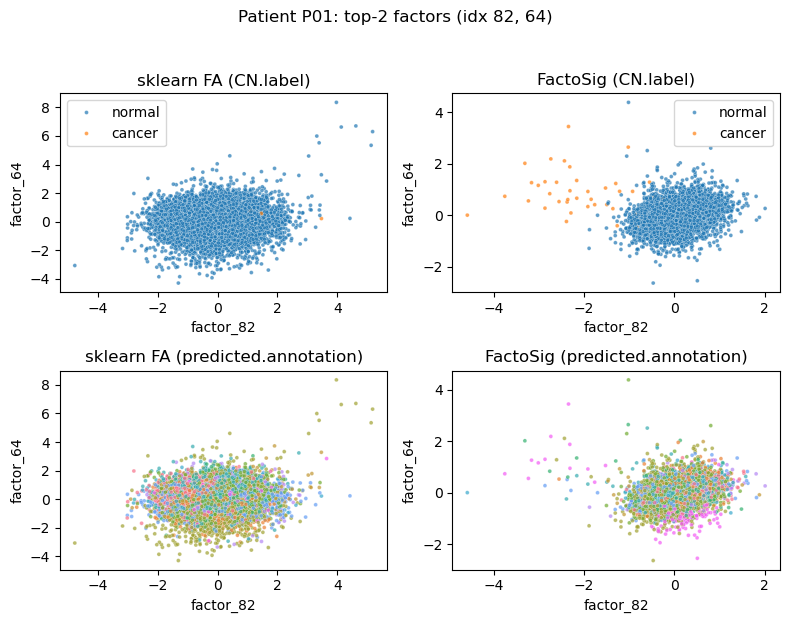

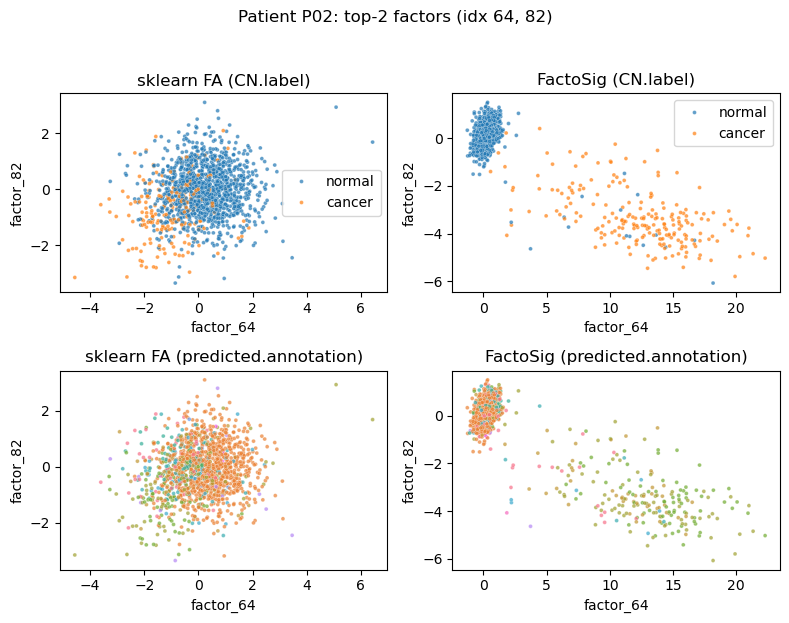

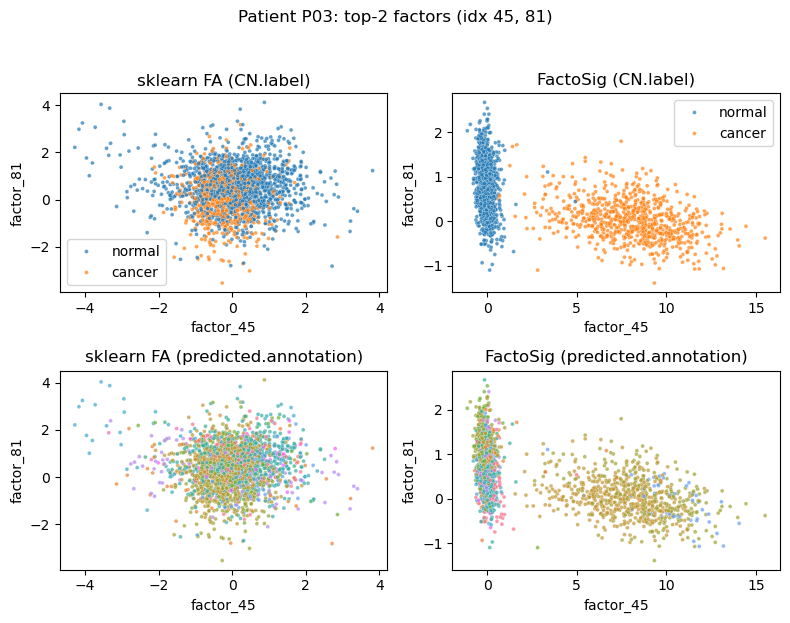

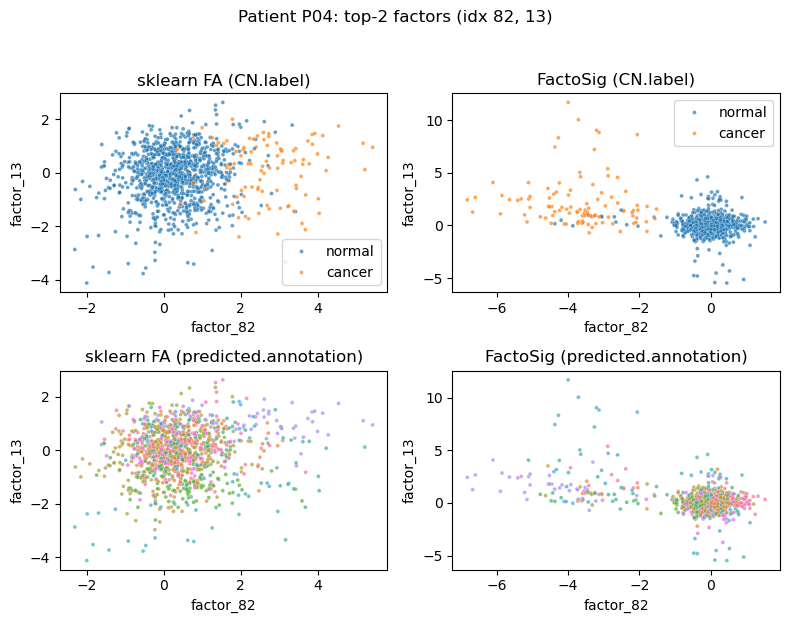

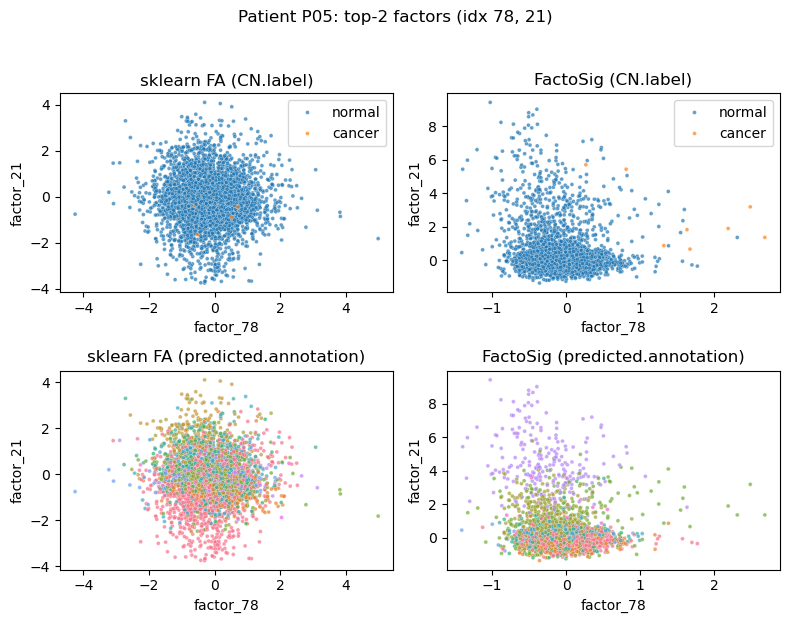

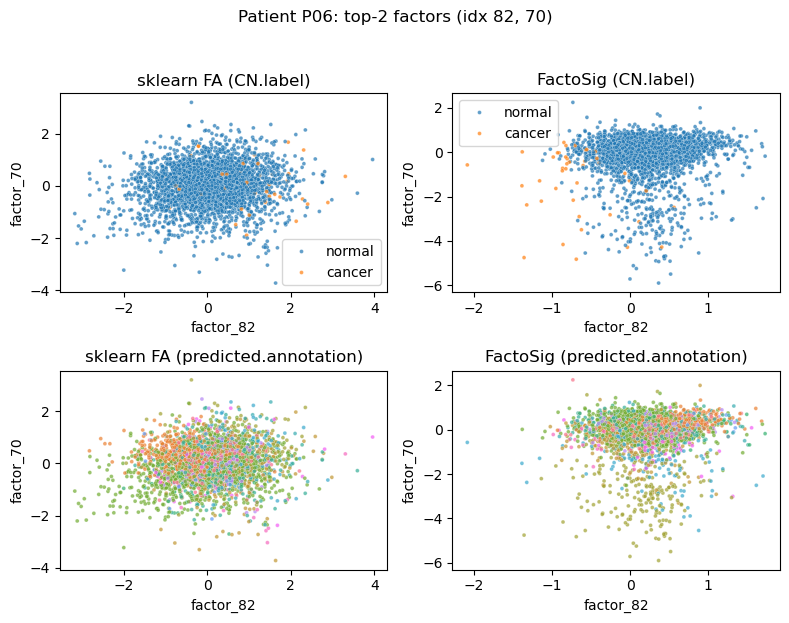

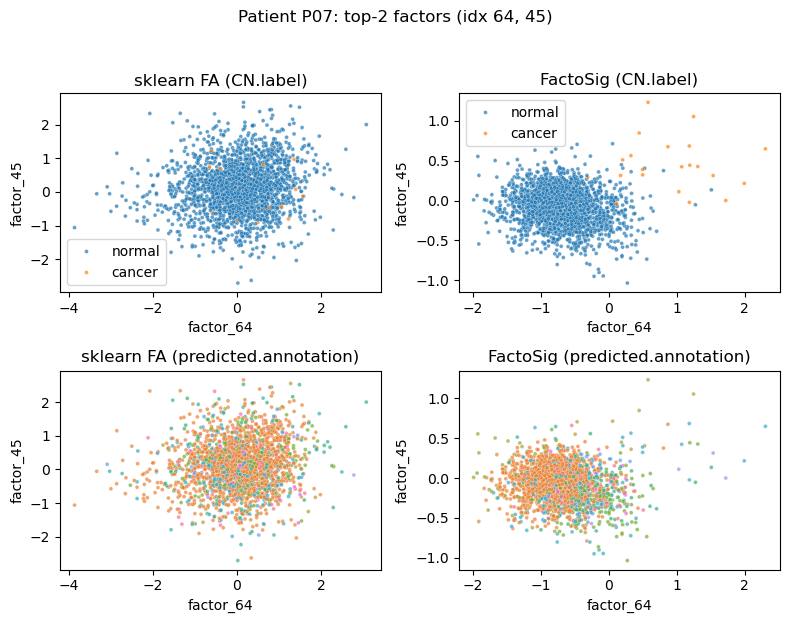

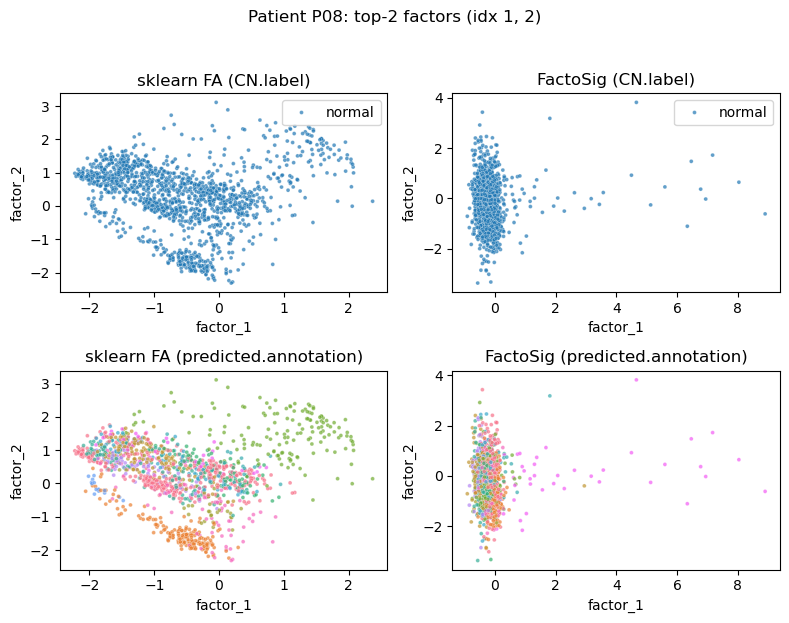

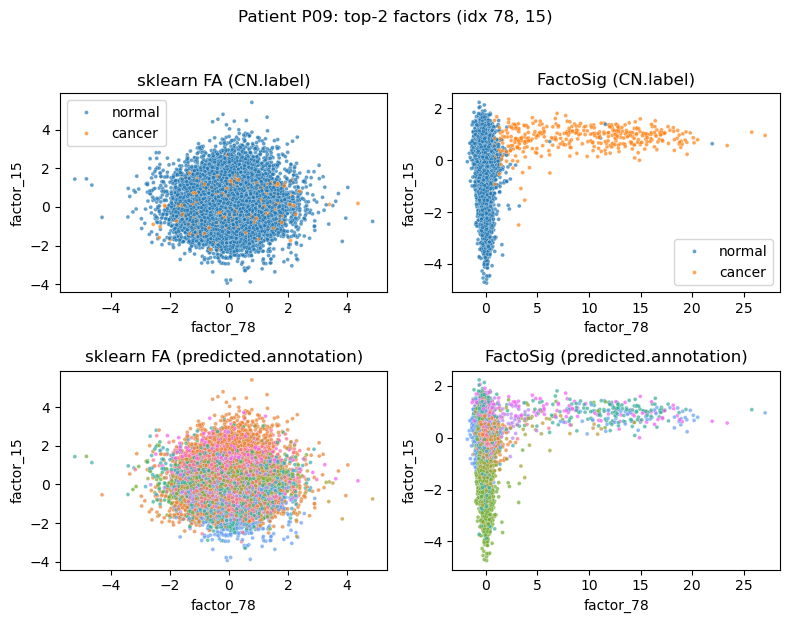

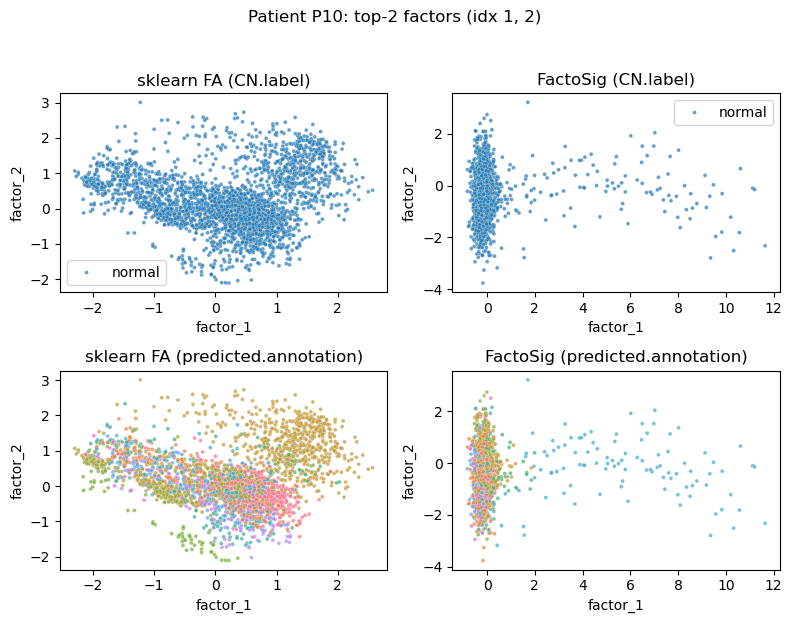

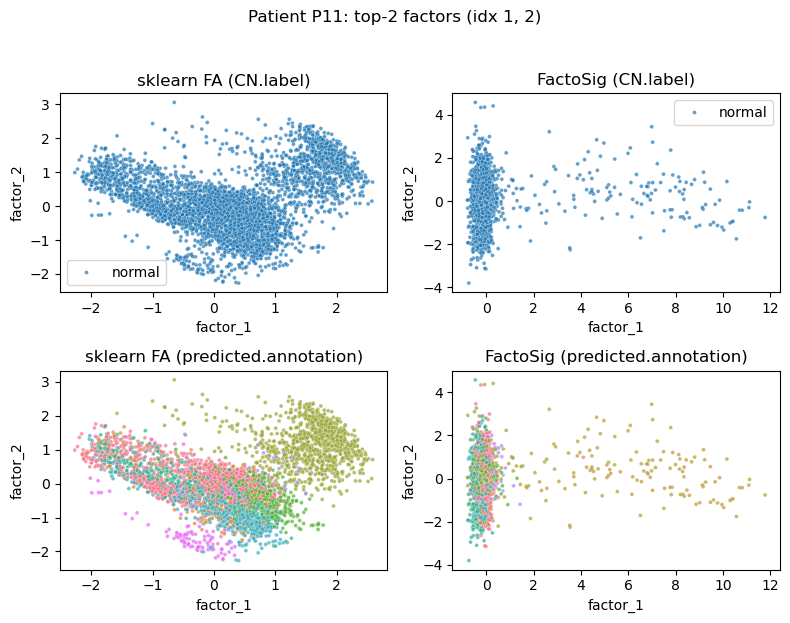

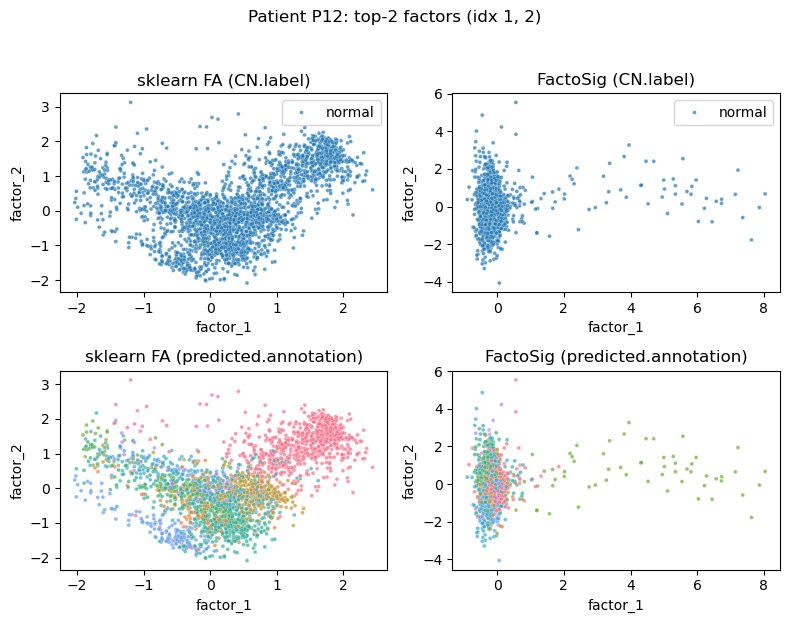

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reload transformed data if needed
# fa_h5ad, fs_h5ad, sklearn_score_key, factosig_score_key should be defined earlier
ad_fa = sc.read_h5ad(fa_h5ad)
ad_fs = sc.read_h5ad(fs_h5ad)

# Ensure patients and labels exist
assert 'patient' in ad_fa.obs and 'CN.label' in ad_fa.obs
label_col = 'CN.label'
anno_col = 'predicted.annotation' if 'predicted.annotation' in ad_fa.obs.columns else None

# Helper to pick top-2 factors per patient by signed AUC (computed earlier)
def top2_factors_for_patient(scores_df: pd.DataFrame, patient_id: str) -> list:
    if patient_id not in scores_df.index:
        return [0, 1]
    row = scores_df.loc[patient_id]
    if row.isna().all():
        return [0, 1]
    order = row.abs().sort_values(ascending=False).index.tolist()
    # columns names like factor_1..factor_k
    top2 = [int(c.split('_')[1]) - 1 for c in order[:2]]
    if len(top2) < 2:
        top2 = [0, 1]
    return top2

# Plot per patient
patients = sorted(pd.unique(ad_fa.obs['patient'].astype(str)))
max_patients_to_show = 12  # adjust for display
for pid in patients[:max_patients_to_show]:
    m_fa = (ad_fa.obs['patient'].astype(str).values == pid)
    m_fs = (ad_fs.obs['patient'].astype(str).values == pid)
    if m_fa.sum() < 5 or m_fs.sum() < 5:
        continue

    # pick top-2 by signed AUC using FactoSig df (or sklearn df, either is fine)
    f1, f2 = top2_factors_for_patient(df_auc_factosig, pid)

    Zfa = np.asarray(ad_fa.obsm[sklearn_score_key])
    Zfs = np.asarray(ad_fs.obsm[factosig_score_key])

    ylab_fa = ad_fa.obs[label_col].astype(str).values
    yanno_fa = ad_fa.obs[anno_col].astype(str).values if anno_col else None
    ylab_fs = ad_fs.obs[label_col].astype(str).values
    yanno_fs = ad_fs.obs[anno_col].astype(str).values if anno_col else None

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    fig.suptitle(f"Patient {pid}: top-2 factors (idx {f1+1}, {f2+1})", y=1.03)

    # sklearn colored by CN.label
    sns.scatterplot(x=Zfa[m_fa, f1], y=Zfa[m_fa, f2], hue=ylab_fa[m_fa], s=8, alpha=0.7, ax=axes[0,0])
    axes[0,0].set_title("sklearn FA (CN.label)")
    axes[0,0].set_xlabel(f"factor_{f1+1}")
    axes[0,0].set_ylabel(f"factor_{f2+1}")

    # FactoSig colored by CN.label
    sns.scatterplot(x=Zfs[m_fs, f1], y=Zfs[m_fs, f2], hue=ylab_fs[m_fs], s=8, alpha=0.7, ax=axes[0,1])
    axes[0,1].set_title("FactoSig (CN.label)")
    axes[0,1].set_xlabel(f"factor_{f1+1}")
    axes[0,1].set_ylabel(f"factor_{f2+1}")

    # sklearn colored by predicted.annotation
    if yanno_fa is not None:
        sns.scatterplot(x=Zfa[m_fa, f1], y=Zfa[m_fa, f2], hue=yanno_fa[m_fa], s=8, alpha=0.7, ax=axes[1,0], legend=False)
        axes[1,0].set_title("sklearn FA (predicted.annotation)")
        axes[1,0].set_xlabel(f"factor_{f1+1}")
        axes[1,0].set_ylabel(f"factor_{f2+1}")

    # FactoSig colored by predicted.annotation
    if yanno_fs is not None:
        sns.scatterplot(x=Zfs[m_fs, f1], y=Zfs[m_fs, f2], hue=yanno_fs[m_fs], s=8, alpha=0.7, ax=axes[1,1], legend=False)
        axes[1,1].set_title("FactoSig (predicted.annotation)")
        axes[1,1].set_xlabel(f"factor_{f1+1}")
        axes[1,1].set_ylabel(f"factor_{f2+1}")

    plt.tight_layout(); plt.show()


In [13]:
df_auc_sklearn

factor_1  factor_2  factor_3  factor_4  factor_5  factor_6  factor_7  \
P01  0.006743  0.188158 -0.112356  0.249925 -0.513703 -0.137464  0.410779   
P03 -0.092367 -0.163373 -0.017414 -0.053946 -0.647524 -0.654574  0.386923   
P02  0.200867 -0.060467 -0.427984 -0.566436 -0.733605 -0.659177 -0.178288   
P05 -0.259538 -0.075213 -0.206619  0.358711 -0.221386 -0.772006  0.458458   
P04  0.085254  0.158048 -0.210507  0.029756 -0.348909 -0.457077  0.502217   
P06 -0.135416 -0.477167 -0.124374 -0.376333  0.241849 -0.398105 -0.178948   
P11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
P07 -0.370571 -0.457656  0.348674 -0.183962 -0.587063  0.048586 -0.249821   
P10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
P12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
P09 -0.169467 -0.315321 -0.084573  0.175082 -0.330956 -0.301674 -0.029142   
P08       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
P13 -0.407539  0.369671 -0.043328  0.106932 -0.128250 -0.729376  0.273917   

     factor_8  factor_9  factor_10  ...  factor_91  factor_92  factor_93  \
P01  0.537800 -0.339077  -0.214272  ...   0.265980   0.275129  -0.282212   
P03  0.200840  0.086861   0.581911  ...  -0.168704  -0.035868  -0.220983   
P02  0.832149 -0.823163  -0.420869  ...  -0.136266   0.102307  -0.017408   
P05  0.863422 -0.327051  -0.353539  ...   0.446851  -0.156918  -0.020168   
P04  0.635000 -0.028150   0.313477  ...   0.374670   0.080170  -0.393304   
P06  0.095532 -0.226792  -0.159402  ...   0.031034  -0.220642   0.044154   
P11       NaN       NaN        NaN  ...        NaN        NaN        NaN   
P07  0.200269 -0.350397   0.054974  ...  -0.227672   0.096121  -0.018157   
P10       NaN       NaN        NaN  ...        NaN        NaN        NaN   
P12       NaN       NaN        NaN  ...        NaN        NaN        NaN   
P09  0.643928 -0.139617  -0.085381  ...  -0.050508   0.102768   0.074108   
P08       NaN       NaN        NaN  ...        NaN        NaN        NaN   
P13  0.809359 -0.197400  -0.705459  ...   0.261698  -0.702340  -0.053033   

     factor_94  factor_95  factor_96  factor_97  factor_98  factor_99  \
P01  -0.148013   0.130145  -0.226501  -0.329899  -0.182651  -0.091652   
P03   0.061423  -0.157940  -0.050478  -0.008901   0.191637  -0.024186   
P02  -0.230621   0.173931  -0.153534   0.017840  -0.112119   0.067597   
P05   0.008676  -0.235578  -0.230981  -0.019363   0.253333  -0.165939   
P04  -0.291729   0.044548  -0.433016  -0.392080   0.039904   0.448553   
P06   0.060540  -0.003718  -0.335388  -0.167157  -0.135742   0.265983   
P11        NaN        NaN        NaN        NaN        NaN        NaN   
P07  -0.295843   0.041693  -0.618585  -0.241416   0.202581   0.283024   
P10        NaN        NaN        NaN        NaN        NaN        NaN   
P12        NaN        NaN        NaN        NaN        NaN        NaN   
P09  -0.046908  -0.121982   0.005404  -0.007714   0.030779   0.010714   
P08        NaN        NaN        NaN        NaN        NaN        NaN   
P13   0.483362   0.609879   0.193934   0.633449   0.182062  -0.532929   

     factor_100  
P01    0.117510  
P03    0.086368  
P02   -0.168627  
P05    0.316307  
P04    0.362248  
P06   -0.237848  
P11         NaN  
P07    0.309167  
P10         NaN  
P12         NaN  
P09    0.066565  
P08         NaN  
P13   -0.252426  

[13 rows x 100 columns]

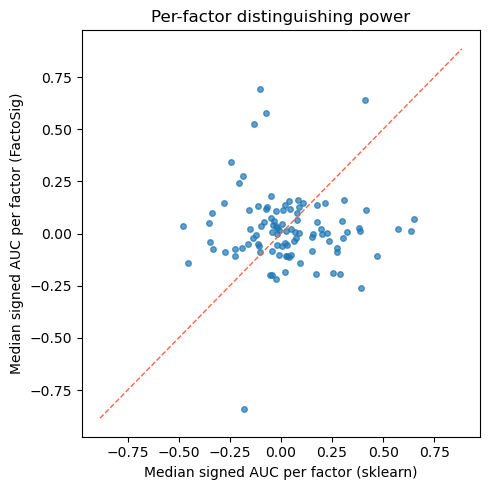

Top 10 factors (FactoSig):
factor_64    0.692384
factor_45    0.639242
factor_78    0.575598
factor_21    0.522607
factor_55    0.342331
factor_44    0.275544
factor_15    0.242628
factor_94    0.178394
factor_61    0.162157
factor_14    0.159197
dtype: float64

Bottom 10 factors (FactoSig):
factor_82   -0.843207
factor_75   -0.262904
factor_52   -0.216913
factor_51   -0.197957
factor_74   -0.197116
factor_16   -0.196078
factor_40   -0.191695
factor_81   -0.188735
factor_88   -0.186266
factor_6    -0.142968
dtype: float64


In [12]:
import matplotlib.pyplot as plt

med_skl = df_auc_sklearn.median(axis=0, skipna=True)
med_fs  = df_auc_factosig.median(axis=0, skipna=True)

plt.figure(figsize=(5,5))
plt.scatter(med_skl, med_fs, s=16, alpha=0.7)
lim = float(np.nanmax(np.abs(np.concatenate([med_skl.values, med_fs.values]))))
lim = 1.05*lim if np.isfinite(lim) and lim>0 else 1.0
plt.plot([-lim, lim], [-lim, lim], c="tomato", ls="--", lw=1)
plt.xlabel("Median signed AUC per factor (sklearn)")
plt.ylabel("Median signed AUC per factor (FactoSig)")
plt.title("Per-factor distinguishing power")
plt.tight_layout(); plt.show()

# Top/bottom factors by FactoSig median
print("Top 10 factors (FactoSig):")
print(med_fs.sort_values(ascending=False).head(10))
print("\nBottom 10 factors (FactoSig):")
print(med_fs.sort_values(ascending=True).head(10))

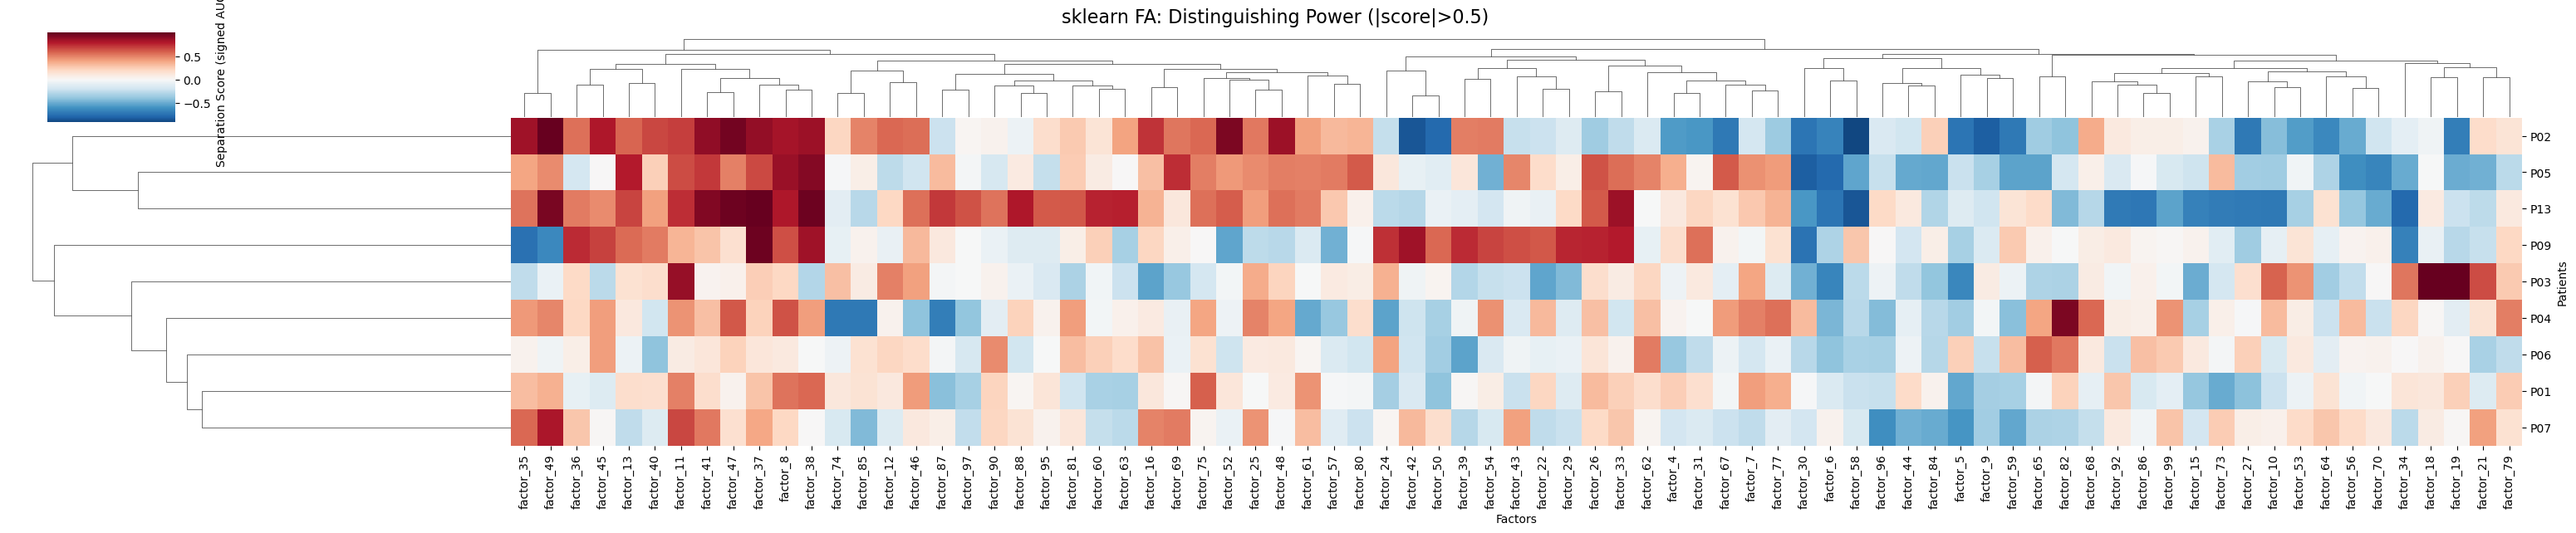

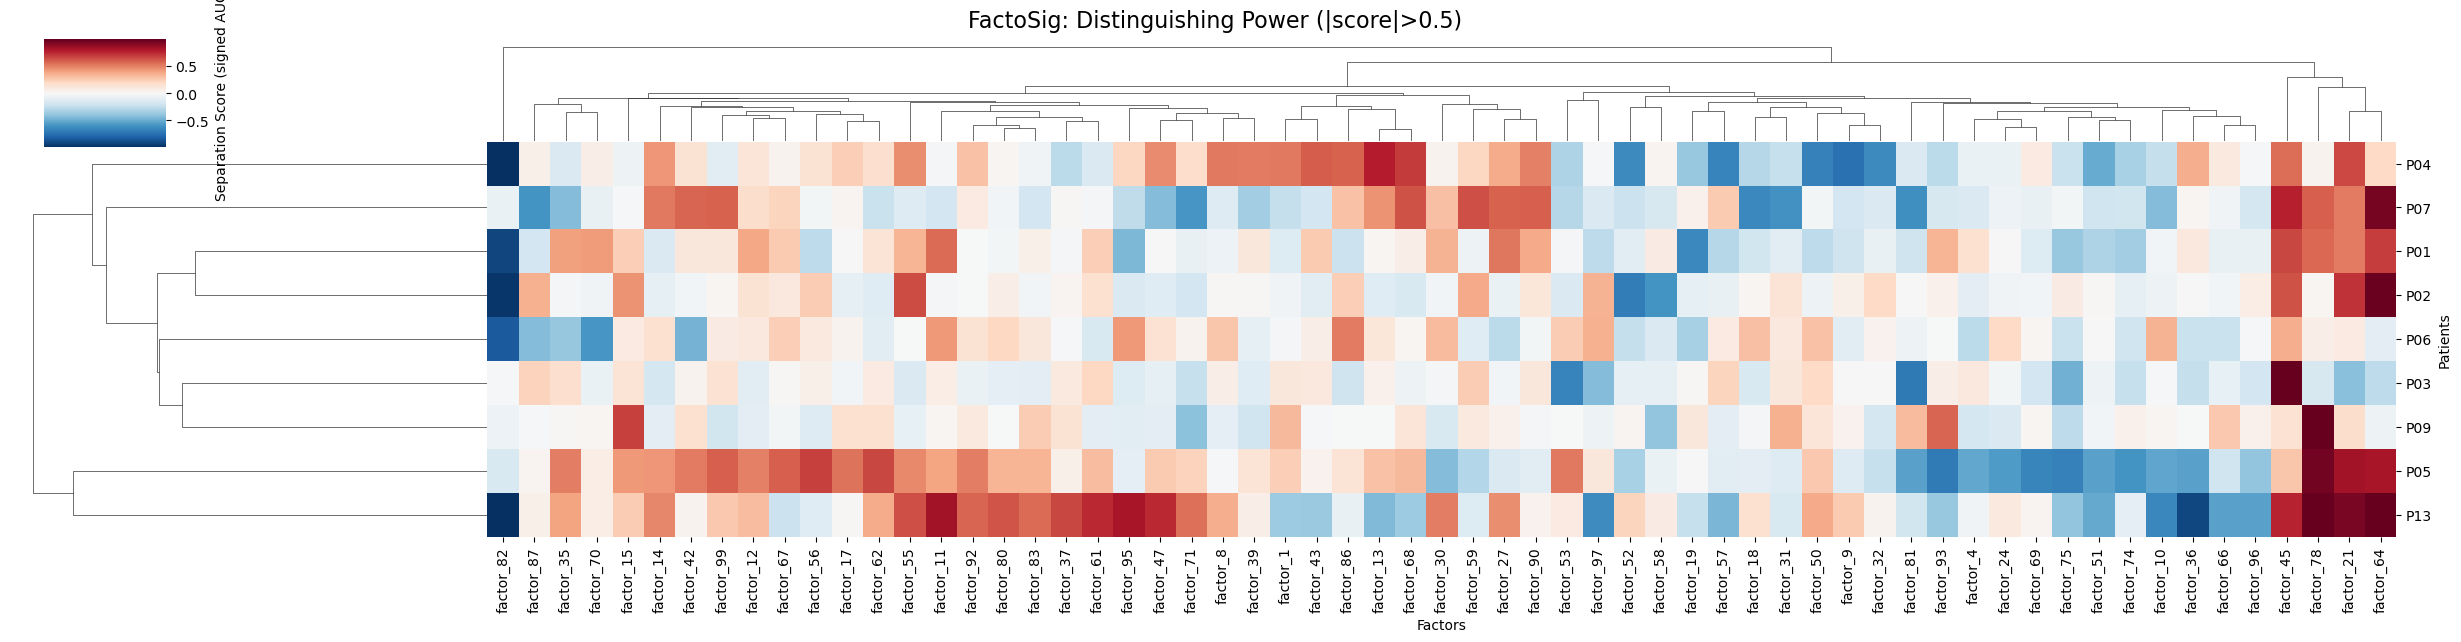

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_clustered_heatmap(scores_df: pd.DataFrame,
                           abs_threshold: float = 0.5,
                           patients_to_exclude=None,
                           title: str = "",
                           figsize_scale=(0.4, 0.6),
                           center=0):
    if patients_to_exclude is None:
        patients_to_exclude = []
    # keep factors with at least one patient above threshold in abs value
    filt_df = scores_df.loc[:, (scores_df.abs() > abs_threshold).any(axis=0)]
    if filt_df.empty:
        print("No factors pass the |score| threshold; plotting all factors instead.")
        filt_df = scores_df.copy()
    # drop excluded patients
    filt_df = filt_df.drop(index=patients_to_exclude, errors="ignore")
    heatmap_data = filt_df.fillna(0.0)

    # figure size scaled by number of columns and rows
    w = max(10, heatmap_data.shape[1] * figsize_scale[0])
    h = max(6, heatmap_data.shape[0] * figsize_scale[1])
    cg = sns.clustermap(
        heatmap_data,
        method="average",
        metric="euclidean",
        cmap="RdBu_r",
        center=center,
        figsize=(w, h),
        cbar_kws={"label": "Separation Score (signed AUC)"},
    )
    cg.fig.suptitle(title or f"Factors with any |score| > {abs_threshold}", fontsize=16, y=1.03)
    cg.ax_heatmap.set_title("")
    plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
    cg.ax_heatmap.set_xlabel("Factors")
    cg.ax_heatmap.set_ylabel("Patients")
    plt.show()

# Example usage:
patients_to_exclude = ['P08', 'P10', 'P11', 'P12']  # optional
plot_clustered_heatmap(
    df_auc_sklearn,
    abs_threshold=0.5,
    patients_to_exclude=patients_to_exclude,
    title="sklearn FA: Distinguishing Power (|score|>0.5)"
)
plot_clustered_heatmap(
    df_auc_factosig,
    abs_threshold=0.5,
    patients_to_exclude=patients_to_exclude,
    title="FactoSig: Distinguishing Power (|score|>0.5)"
)

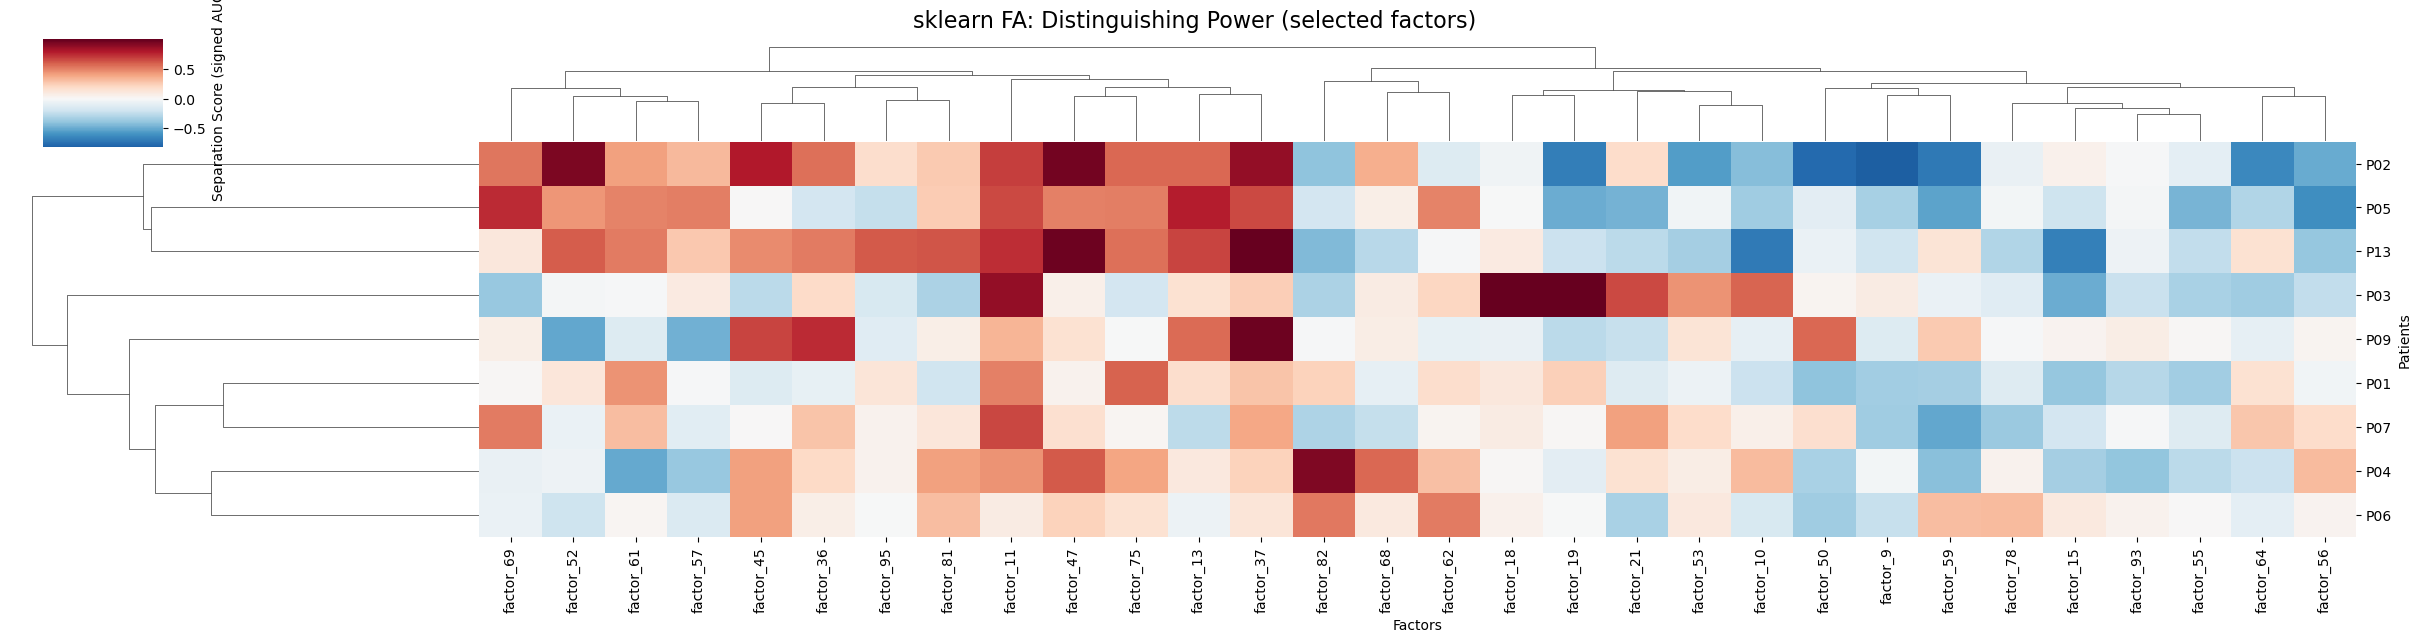

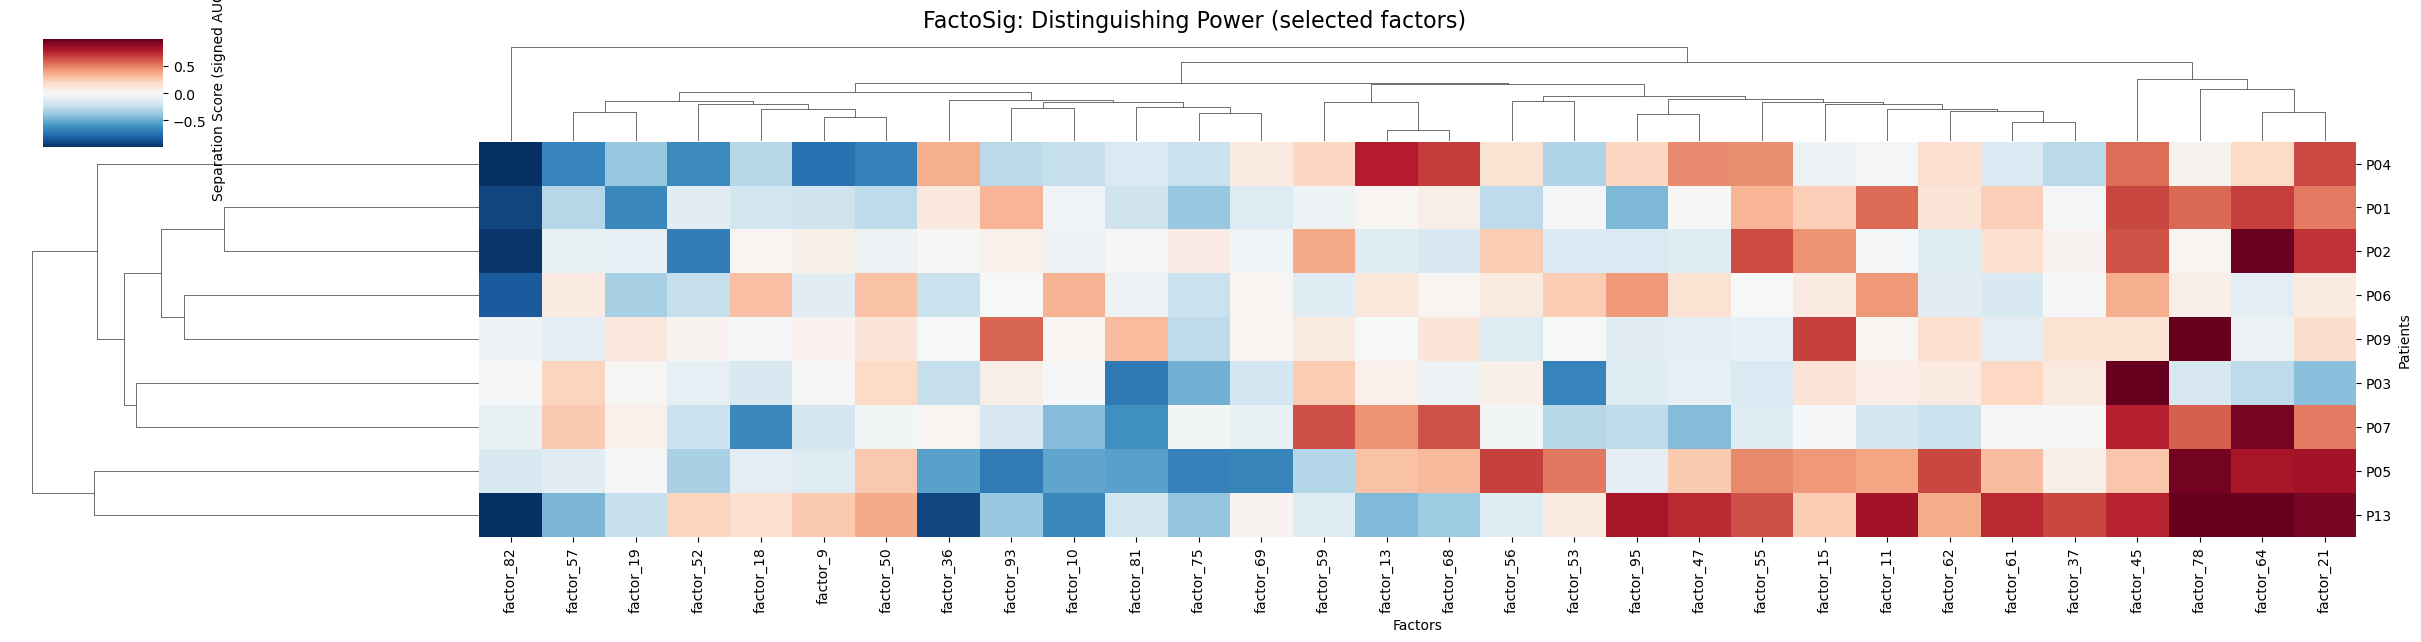

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Option A: if you have a CSV listing active factor names (columns in the scores df)
# active_factors = pd.read_csv("active_factor_names_from_pan_patient_model.csv")["active_factor_name"].tolist()

# Option B: derive top-N by max absolute separation (fallback)
def top_factors_by_max_abs(scores_df: pd.DataFrame, top_n: int = 30):
    max_abs = scores_df.abs().max(axis=0)
    return max_abs.sort_values(ascending=False).head(top_n).index.tolist()

active_factors = top_factors_by_max_abs(df_auc_factosig, top_n=30)  # or df_auc_sklearn

def plot_active_heatmap(scores_df: pd.DataFrame,
                        active_factors: list,
                        patients_to_exclude=None,
                        title: str = "",
                        figsize_scale=(0.8, 0.6),
                        center=0):
    if patients_to_exclude is None:
        patients_to_exclude = []
    heatmap_data = scores_df[active_factors].fillna(0.0)
    heatmap_data = heatmap_data.drop(index=patients_to_exclude, errors="ignore")
    w = max(8, len(active_factors) * figsize_scale[0])
    h = max(6, heatmap_data.shape[0] * figsize_scale[1])
    cg = sns.clustermap(
        heatmap_data,
        method="average",
        metric="euclidean",
        cmap="RdBu_r",
        center=center,
        figsize=(w, h),
        cbar_kws={"label": "Separation Score (signed AUC)"},
    )
    cg.fig.suptitle(title or f"Distinguishing Power of {len(active_factors)} Selected Factors", fontsize=16, y=1.03)
    cg.ax_heatmap.set_title("")
    plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)
    cg.ax_heatmap.set_xlabel("Factors")
    cg.ax_heatmap.set_ylabel("Patients")
    plt.show()

# Example usage:
plot_active_heatmap(
    df_auc_sklearn,
    active_factors,
    patients_to_exclude=patients_to_exclude,
    title="sklearn FA: Distinguishing Power (selected factors)"
)
plot_active_heatmap(
    df_auc_factosig,
    active_factors,
    patients_to_exclude=patients_to_exclude,
    title="FactoSig: Distinguishing Power (selected factors)"
)